In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from funkwpap import *
import sympy as sp, pandas as pd, numpy as np, tqdm, time, sys, matplotlib.pyplot as plt, tqdm
from statistics import mean
from scipy.optimize import fsolve
from random import random


In [2]:
x = sp.symbols('x')
cap = 2000 # total emission cap
Regulator23 = Regulator("test1", permit_price = 2.4079, emission_cap = cap)
sector1 = Sector('cement', price_demand_function= 100 - 0.1*x, free_emission_multiplier= 0, regulator= Regulator23)
sector2 = Sector('steel', price_demand_function=150 - 0.1*x, free_emission_multiplier= 0, regulator= Regulator23)
sector3 = Sector('paper', price_demand_function= 200 - 0.02*x**1.5, free_emission_multiplier= 0, regulator= Regulator23)
country1 = Country('DE', 1, regulator= Regulator23)
country2 = Country('FI', 0.5, regulator= Regulator23)
country3 = Country('GR', size= 0.1, regulator= Regulator23)

# Create Firms using objects
firm1 = Firm('firm1', 1, 1, x*0, 2*x+ 2*x**2 + 2*x**3 , 0, 0, 0, regulator= Regulator23)
firm2 = Firm('firm2', 1, 2, x*0, 3*x+ 3*x**2 + 2*x**3, 0, 0, 0, regulator= Regulator23)
firm3 = Firm('firm3', 1, 3, x*0, 1*x+ 3*x**2 + 2*x**3 , 0, 0, 0, regulator= Regulator23)
firm4 = Firm('firm4', 2, 1, x*0, 7*x+ 5*x**2 + 3*x**3 , 0, 0, 0, regulator= Regulator23)
firm5 = Firm('firm5', 2, 2, x*0, 1*x+ 6*x**2 + 2*x**3 , 0, 0, 0, regulator= Regulator23)
firm6 = Firm('firm6', 2, 3, x*0, 2*x+ 7*x**2 + 3*x**3 , 0, 0, 0, regulator= Regulator23)
firm7 = Firm('firm7', 3, 1, x*0, 3*x+ 8*x**2 + 4*x**3 , 0, 0, 0, regulator= Regulator23)
firm8 = Firm('firm8', 3, 2, x*0, 4*x+ 9*x**2 + 10*x**3 , 0, 0, 0, regulator= Regulator23)
firm9 = Firm('firm9', 3, 3, x*0, 5*x+ 10*x**2 + 11*x**3 , 0, 0, 0, regulator= Regulator23)



In [3]:
Regulator23.BAU_calculator()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-14


In [4]:
# Define the percentages of BAU emissions
bau_percentages = [0.7, 0.8, 0.9]

# Initialize dictionaries to store results for each percentage
results = {perc: {
    'profits1': [], 'profits2': [], 'abatements1': [], 'abatements2': [],
    'permits1': [], 'permits2': [], 'trades1': [], 'trades2': [],
    'revenews1': [], 'revenews2': [], 'permit_price': [],
    'outputs1': [], 'outputs2': [], 'emissions1': [], 'emissions2': []
} for perc in bau_percentages}

# Loop over each percentage
for perc in bau_percentages:
    Regulator23.emission_cap = Regulator23.BAU_emissions * perc
    frees = np.linspace(0, 1, 100)

    for free in tqdm.tqdm(frees):
        sector1.free_emission_multiplier = free
        Regulator23.optimization_concave_formulation_ab()
        print(f"{free}: {Regulator23.equilibrium_tester(output=True)}")

        for firm in Regulator23.firm_registry.values():
            firm.calculate_profit_components()

        results[perc]['profits1'].append(mean(float(i.profit) for i in sector1.firms))
        results[perc]['profits2'].append(mean(float(i.profit) for i in sector2.firms + sector3.firms))
        results[perc]['abatements1'].append(mean(float(i.abatement) for i in sector1.firms))
        results[perc]['abatements2'].append(mean(float(i.abatement) for i in sector2.firms + sector3.firms))
        results[perc]['permits1'].append(mean(float(i.permits_used) for i in sector1.firms))
        results[perc]['permits2'].append(mean(float(i.permits_used) for i in sector2.firms + sector3.firms))
        results[perc]['trades1'].append(mean(float(i.permits_costs) for i in sector1.firms))
        results[perc]['trades2'].append(mean(float(i.permits_costs) for i in sector2.firms + sector3.firms))
        results[perc]['revenews1'].append(mean(float(i.sales) for i in sector1.firms))
        results[perc]['revenews2'].append(mean(float(i.sales) for i in sector2.firms + sector3.firms))
        results[perc]['permit_price'].append(Regulator23.permit_price)
        results[perc]['outputs1'].append(mean(float(i.actual_output) for i in sector1.firms))
        results[perc]['outputs2'].append(mean(float(i.actual_output) for i in sector2.firms + sector3.firms))
        results[perc]['emissions1'].append(mean(float(i.emission) for i in sector1.firms))
        results[perc]['emissions2'].append(mean(float(i.emission) for i in sector2.firms + sector3.firms))



  0%|          | 0/100 [00:00<?, ?it/s]

Optimal solution found


  1%|          | 1/100 [00:02<04:13,  2.56s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0044 ⚠️ |  +7.95e-6 ✔️ |  -30.5145 ✔️ |  -30.7145 ✔️ |   +6.1029 ✔️ | 4/5
0.0: (False, 0.00437373124920981)
Optimal solution found


  2%|▏         | 2/100 [00:06<05:42,  3.49s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0064 ⚠️ |  +1.15e-5 ✔️ |  -30.5874 ✔️ |  -30.7874 ✔️ |   +6.1175 ✔️ | 4/5
0.010101010101010102: (False, 0.00637922985335848)
Optimal solution found


  3%|▎         | 3/100 [00:09<05:10,  3.21s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0084 ⚠️ |  +7.03e-6 ✔️ |  -30.6608 ✔️ |  -30.8608 ✔️ |   +6.1322 ✔️ | 4/5
0.020202020202020204: (False, 0.00836453251422853)
Optimal solution found


  4%|▍         | 4/100 [00:11<04:28,  2.79s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0162 ⚠️ |  +1.72e-5 ✔️ |  -30.7347 ✔️ |  -30.9347 ✔️ |   +6.1469 ✔️ | 4/5
0.030303030303030304: (False, 0.0161871803218077)
Optimal solution found


  5%|▌         | 5/100 [00:15<04:46,  3.02s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0123 ⚠️ |  +3.22e-6 ✔️ |  -30.8092 ✔️ |  -31.0092 ✔️ |   +6.1618 ✔️ | 4/5
0.04040404040404041: (False, 0.0122655614715832)
Optimal solution found


  6%|▌         | 6/100 [00:17<04:28,  2.85s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0142 ⚠️ |  +7.00e-6 ✔️ |  -30.8842 ✔️ |  -31.0842 ✔️ |   +6.1768 ✔️ | 4/5
0.05050505050505051: (False, 0.0141800520940372)
Optimal solution found


  7%|▋         | 7/100 [00:20<04:30,  2.91s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0161 ⚠️ |  +2.68e-5 ✔️ |  -30.9597 ✔️ |  -31.1597 ✔️ |   +6.1919 ✔️ | 4/5
0.06060606060606061: (False, 0.0160582884945342)
Optimal solution found


  8%|▊         | 8/100 [00:23<04:39,  3.03s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0179 ⚠️ |  +2.29e-5 ✔️ |  -31.0357 ✔️ |  -31.2357 ✔️ |   +6.2071 ✔️ | 4/5
0.07070707070707072: (False, 0.0179064401381126)
Optimal solution found


  9%|▉         | 9/100 [00:27<04:47,  3.16s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0198 ⚠️ |  +2.34e-5 ✔️ |  -31.1123 ✔️ |  -31.3123 ✔️ |   +6.2225 ✔️ | 4/5
0.08080808080808081: (False, 0.0197710086795446)
Optimal solution found


 10%|█         | 10/100 [00:31<04:56,  3.29s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0215 ⚠️ |  +2.71e-5 ✔️ |  -31.1894 ✔️ |  -31.3894 ✔️ |   +6.2379 ✔️ | 4/5
0.09090909090909091: (False, 0.0215463023323075)
Optimal solution found


 11%|█         | 11/100 [00:35<05:12,  3.51s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0233 ⚠️ |  +3.63e-5 ✔️ |  -31.2670 ✔️ |  -31.4670 ✔️ |   +6.2534 ✔️ | 4/5
0.10101010101010102: (False, 0.0233155488076022)
Optimal solution found


 12%|█▏        | 12/100 [00:37<04:46,  3.25s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0250 ⚠️ |  +2.63e-5 ✔️ |  -31.3452 ✔️ |  -31.5452 ✔️ |   +6.2690 ✔️ | 4/5
0.11111111111111112: (False, 0.0250473339786623)
Optimal solution found


 13%|█▎        | 13/100 [00:40<04:41,  3.23s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0268 ⚠️ |  +7.23e-6 ✔️ |  -31.4240 ✔️ |  -31.6240 ✔️ |   +6.2848 ✔️ | 4/5
0.12121212121212122: (False, 0.0267568329431924)
Optimal solution found


 14%|█▍        | 14/100 [00:43<04:30,  3.15s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0284 ⚠️ |  +1.88e-5 ✔️ |  -31.5033 ✔️ |  -31.7033 ✔️ |   +6.3007 ✔️ | 4/5
0.13131313131313133: (False, 0.0284290793445656)
Optimal solution found


 15%|█▌        | 15/100 [00:47<04:38,  3.27s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0301 ⚠️ |  +2.45e-5 ✔️ |  -31.5833 ✔️ |  -31.7833 ✔️ |   +6.3167 ✔️ | 4/5
0.14141414141414144: (False, 0.0300624060817469)
Optimal solution found


 16%|█▌        | 16/100 [00:50<04:36,  3.29s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0317 ⚠️ |  +3.34e-6 ✔️ |  -31.6638 ✔️ |  -31.8638 ✔️ |   +6.3328 ✔️ | 4/5
0.15151515151515152: (False, 0.0316596807254363)
Optimal solution found


 17%|█▋        | 17/100 [00:53<04:17,  3.11s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0332 ⚠️ |  +2.49e-5 ✔️ |  -31.7449 ✔️ |  -31.9449 ✔️ |   +6.3490 ✔️ | 4/5
0.16161616161616163: (False, 0.0332085715513273)
Optimal solution found


 18%|█▊        | 18/100 [00:56<04:25,  3.24s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0347 ⚠️ |  +8.76e-6 ✔️ |  -31.8265 ✔️ |  -32.0265 ✔️ |   +6.3653 ✔️ | 4/5
0.17171717171717174: (False, 0.0347440231205702)
Optimal solution found


 19%|█▉        | 19/100 [01:00<04:28,  3.31s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0362 ⚠️ |  +5.66e-6 ✔️ |  -31.9088 ✔️ |  -32.1088 ✔️ |   +6.3818 ✔️ | 4/5
0.18181818181818182: (False, 0.0362159789017618)
Optimal solution found


 20%|██        | 20/100 [01:04<04:42,  3.53s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0376 ⚠️ |  +4.21e-6 ✔️ |  -31.9918 ✔️ |  -32.1918 ✔️ |   +6.3984 ✔️ | 4/5
0.19191919191919193: (False, 0.0376473168892808)
Optimal solution found


 21%|██        | 21/100 [01:09<05:18,  4.03s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0390 ⚠️ |  +2.21e-5 ✔️ |  -32.0753 ✔️ |  -32.2753 ✔️ |   +6.4151 ✔️ | 4/5
0.20202020202020204: (False, 0.0390263021062971)
Optimal solution found


 22%|██▏       | 22/100 [01:12<04:34,  3.52s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0532 ⚠️ |  +5.05e-6 ✔️ |  -32.1593 ✔️ |  -32.3593 ✔️ |   +6.4319 ✔️ | 4/5
0.21212121212121213: (False, 0.0532243500940481)
Optimal solution found


 23%|██▎       | 23/100 [01:15<04:29,  3.50s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0417 ⚠️ |  +1.67e-5 ✔️ |  -32.2443 ✔️ |  -32.4443 ✔️ |   +6.4489 ✔️ | 4/5
0.22222222222222224: (False, 0.0416683359251628)
Optimal solution found


 24%|██▍       | 24/100 [01:18<04:26,  3.50s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0429 ⚠️ |  +2.59e-5 ✔️ |  -32.3297 ✔️ |  -32.5297 ✔️ |   +6.4659 ✔️ | 4/5
0.23232323232323235: (False, 0.0429103283856946)
Optimal solution found


 25%|██▌       | 25/100 [01:23<04:37,  3.71s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0441 ⚠️ |  +2.70e-5 ✔️ |  -32.4158 ✔️ |  -32.6158 ✔️ |   +6.4832 ✔️ | 4/5
0.24242424242424243: (False, 0.0441289178646116)
Optimal solution found


 26%|██▌       | 26/100 [01:26<04:31,  3.67s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0453 ⚠️ |  +1.20e-5 ✔️ |  -32.5026 ✔️ |  -32.7026 ✔️ |   +6.5005 ✔️ | 4/5
0.25252525252525254: (False, 0.0452511734204180)
Optimal solution found


 27%|██▋       | 27/100 [01:29<04:12,  3.46s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0463 ⚠️ |  +2.59e-5 ✔️ |  -32.5900 ✔️ |  -32.7900 ✔️ |   +6.5180 ✔️ | 4/5
0.26262626262626265: (False, 0.0463202302178196)
Optimal solution found


 28%|██▊       | 28/100 [01:32<03:45,  3.13s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0473 ⚠️ |  +1.44e-5 ✔️ |  -32.6781 ✔️ |  -32.8781 ✔️ |   +6.5356 ✔️ | 4/5
0.27272727272727276: (False, 0.0473424972675005)
Optimal solution found


 29%|██▉       | 29/100 [01:34<03:34,  3.03s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0483 ⚠️ |  +2.26e-5 ✔️ |  -32.7669 ✔️ |  -32.9669 ✔️ |   +6.5534 ✔️ | 4/5
0.2828282828282829: (False, 0.0483084733367072)
Optimal solution found


 30%|███       | 30/100 [01:38<03:44,  3.21s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0492 ⚠️ |  +3.72e-6 ✔️ |  -32.8564 ✔️ |  -33.0564 ✔️ |   +6.5713 ✔️ | 4/5
0.29292929292929293: (False, 0.0492098625898727)
Optimal solution found


 31%|███       | 31/100 [01:41<03:36,  3.14s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0500 ⚠️ |  +1.52e-5 ✔️ |  -32.9466 ✔️ |  -33.1466 ✔️ |   +6.5893 ✔️ | 4/5
0.30303030303030304: (False, 0.0500449401154164)
Optimal solution found


 32%|███▏      | 32/100 [01:44<03:36,  3.18s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0508 ⚠️ |  +3.41e-6 ✔️ |  -33.0376 ✔️ |  -33.2376 ✔️ |   +6.6075 ✔️ | 4/5
0.31313131313131315: (False, 0.0508116616625394)
Optimal solution found


 33%|███▎      | 33/100 [01:47<03:30,  3.14s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0515 ⚠️ |  +3.03e-6 ✔️ |  -33.1292 ✔️ |  -33.3292 ✔️ |   +6.6258 ✔️ | 4/5
0.32323232323232326: (False, 0.0515172405445732)
Optimal solution found


 34%|███▍      | 34/100 [01:50<03:26,  3.14s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0521 ⚠️ |  +6.88e-6 ✔️ |  -33.2216 ✔️ |  -33.4216 ✔️ |   +6.6443 ✔️ | 4/5
0.33333333333333337: (False, 0.0521382467991316)
Optimal solution found


 35%|███▌      | 35/100 [01:54<03:24,  3.14s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0527 ⚠️ |  +4.28e-6 ✔️ |  -33.3147 ✔️ |  -33.5147 ✔️ |   +6.6629 ✔️ | 4/5
0.3434343434343435: (False, 0.0526993171054642)
Optimal solution found


 36%|███▌      | 36/100 [01:57<03:25,  3.21s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0532 ⚠️ |  +7.14e-6 ✔️ |  -33.4086 ✔️ |  -33.6086 ✔️ |   +6.6817 ✔️ | 4/5
0.3535353535353536: (False, 0.0531709458394189)
Optimal solution found


 37%|███▋      | 37/100 [02:00<03:18,  3.15s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0536 ⚠️ |  +2.62e-5 ✔️ |  -33.5033 ✔️ |  -33.7033 ✔️ |   +6.7007 ✔️ | 4/5
0.36363636363636365: (False, 0.0535630803915943)
Optimal solution found


 38%|███▊      | 38/100 [02:03<03:12,  3.10s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0539 ⚠️ |  +3.68e-6 ✔️ |  -33.5987 ✔️ |  -33.7987 ✔️ |   +6.7197 ✔️ | 4/5
0.37373737373737376: (False, 0.0538818422529381)
Optimal solution found


 39%|███▉      | 39/100 [02:06<03:12,  3.15s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0541 ⚠️ |  +2.92e-5 ✔️ |  -33.6949 ✔️ |  -33.8949 ✔️ |   +6.7390 ✔️ | 4/5
0.38383838383838387: (False, 0.0541435810972395)
Optimal solution found


 40%|████      | 40/100 [02:09<03:05,  3.09s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0542 ⚠️ |  +2.63e-5 ✔️ |  -33.7920 ✔️ |  -33.9920 ✔️ |   +6.7584 ✔️ | 4/5
0.393939393939394: (False, 0.0542415378241650)
Optimal solution found


 41%|████      | 41/100 [02:13<03:14,  3.30s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0543 ⚠️ |  +2.72e-5 ✔️ |  -33.8898 ✔️ |  -34.0898 ✔️ |   +6.7780 ✔️ | 4/5
0.4040404040404041: (False, 0.0542870022176949)
Optimal solution found


 42%|████▏     | 42/100 [02:16<03:03,  3.16s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0542 ⚠️ |  +1.09e-5 ✔️ |  -33.9884 ✔️ |  -34.1884 ✔️ |   +6.7977 ✔️ | 4/5
0.4141414141414142: (False, 0.0542407220772283)
Optimal solution found


 43%|████▎     | 43/100 [02:18<02:52,  3.02s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0541 ⚠️ |  +1.75e-5 ✔️ |  -34.0879 ✔️ |  -34.2879 ✔️ |   +6.8176 ✔️ | 4/5
0.42424242424242425: (False, 0.0540912065286854)
Optimal solution found


 44%|████▍     | 44/100 [02:21<02:48,  3.02s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0548 ⚠️ |  +9.87e-6 ✔️ |  -34.1882 ✔️ |  -34.3882 ✔️ |   +6.8376 ✔️ | 4/5
0.43434343434343436: (False, 0.0547595110016843)
Optimal solution found


 45%|████▌     | 45/100 [02:25<02:46,  3.02s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0535 ⚠️ |  +2.65e-5 ✔️ |  -34.2894 ✔️ |  -34.4894 ✔️ |   +6.8579 ✔️ | 4/5
0.4444444444444445: (False, 0.0534738405782598)
Optimal solution found


 46%|████▌     | 46/100 [02:28<02:44,  3.04s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0530 ⚠️ |  +2.67e-5 ✔️ |  -34.3915 ✔️ |  -34.5915 ✔️ |   +6.8783 ✔️ | 4/5
0.4545454545454546: (False, 0.0530067587857630)
Optimal solution found


 47%|████▋     | 47/100 [02:31<02:44,  3.11s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0524 ⚠️ |  +1.31e-5 ✔️ |  -34.4944 ✔️ |  -34.6944 ✔️ |   +6.8989 ✔️ | 4/5
0.4646464646464647: (False, 0.0524265083092104)
Optimal solution found


 48%|████▊     | 48/100 [02:34<02:43,  3.15s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0517 ⚠️ |  +2.65e-5 ✔️ |  -34.5983 ✔️ |  -34.7983 ✔️ |   +6.9197 ✔️ | 4/5
0.4747474747474748: (False, 0.0517207202599899)
Optimal solution found


 49%|████▉     | 49/100 [02:37<02:32,  2.99s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0509 ⚠️ |  +1.88e-5 ✔️ |  -34.7030 ✔️ |  -34.9030 ✔️ |   +6.9406 ✔️ | 4/5
0.48484848484848486: (False, 0.0508984421403724)
Optimal solution found


 50%|█████     | 50/100 [02:39<02:24,  2.89s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0499 ⚠️ |  +1.79e-5 ✔️ |  -34.8087 ✔️ |  -35.0087 ✔️ |   +6.9617 ✔️ | 4/5
0.494949494949495: (False, 0.0499456756190888)
Optimal solution found


 51%|█████     | 51/100 [02:43<02:25,  2.97s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0489 ⚠️ |  +7.41e-6 ✔️ |  -34.9153 ✔️ |  -35.1153 ✔️ |   +6.9831 ✔️ | 4/5
0.5050505050505051: (False, 0.0488534403318823)
Optimal solution found


 52%|█████▏    | 52/100 [02:46<02:24,  3.01s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0476 ⚠️ |  +2.40e-5 ✔️ |  -35.0228 ✔️ |  -35.2228 ✔️ |   +7.0046 ✔️ | 4/5
0.5151515151515152: (False, 0.0476390363506347)
Optimal solution found


 53%|█████▎    | 53/100 [02:48<02:17,  2.93s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0463 ⚠️ |  +4.40e-6 ✔️ |  -35.1313 ✔️ |  -35.3313 ✔️ |   +7.0263 ✔️ | 4/5
0.5252525252525253: (False, 0.0462869257113674)
Optimal solution found


 54%|█████▍    | 54/100 [02:51<02:13,  2.90s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0448 ⚠️ |  +9.47e-6 ✔️ |  -35.2408 ✔️ |  -35.4408 ✔️ |   +7.0482 ✔️ | 4/5
0.5353535353535354: (False, 0.0447736862228751)
Optimal solution found


 55%|█████▌    | 55/100 [02:54<02:12,  2.95s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0431 ⚠️ |  +7.22e-6 ✔️ |  -35.3513 ✔️ |  -35.5513 ✔️ |   +7.0703 ✔️ | 4/5
0.5454545454545455: (False, 0.0431007665702303)
Optimal solution found


 56%|█████▌    | 56/100 [02:57<02:09,  2.95s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0417 ⚠️ |  +1.86e-6 ✔️ |  -35.4628 ✔️ |  -35.6628 ✔️ |   +7.0926 ✔️ | 4/5
0.5555555555555556: (False, 0.0416899606159085)
Optimal solution found


 57%|█████▋    | 57/100 [03:00<02:06,  2.95s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0393 ⚠️ |  +6.01e-6 ✔️ |  -35.5753 ✔️ |  -35.7753 ✔️ |   +7.1151 ✔️ | 4/5
0.5656565656565657: (False, 0.0392942794652420)
Optimal solution found


 58%|█████▊    | 58/100 [03:03<02:05,  2.99s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0371 ⚠️ |  +2.67e-7 ✔️ |  -35.6889 ✔️ |  -35.8889 ✔️ |   +7.1378 ✔️ | 4/5
0.5757575757575758: (False, 0.0371382427459750)
Optimal solution found


 59%|█████▉    | 59/100 [03:06<02:03,  3.01s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0348 ⚠️ |  +4.47e-6 ✔️ |  -35.8035 ✔️ |  -36.0035 ✔️ |   +7.1607 ✔️ | 4/5
0.5858585858585859: (False, 0.0348181632115754)
Optimal solution found


 60%|██████    | 60/100 [03:09<01:58,  2.97s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0323 ⚠️ |  +5.58e-6 ✔️ |  -35.9191 ✔️ |  -36.1191 ✔️ |   +7.1838 ✔️ | 4/5
0.595959595959596: (False, 0.0322909659526687)
Optimal solution found


 61%|██████    | 61/100 [03:12<01:56,  2.98s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0296 ⚠️ |  +1.96e-5 ✔️ |  -36.0359 ✔️ |  -36.2359 ✔️ |   +7.2072 ✔️ | 4/5
0.6060606060606061: (False, 0.0295862372224533)
Optimal solution found


 62%|██████▏   | 62/100 [03:15<01:51,  2.94s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0267 ⚠️ |  +2.10e-7 ✔️ |  -36.1538 ✔️ |  -36.3538 ✔️ |   +7.2308 ✔️ | 4/5
0.6161616161616162: (False, 0.0266852535991262)
Optimal solution found


 63%|██████▎   | 63/100 [03:18<01:49,  2.96s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0236 ⚠️ |  +6.26e-6 ✔️ |  -36.2728 ✔️ |  -36.4728 ✔️ |   +7.2546 ✔️ | 4/5
0.6262626262626263: (False, 0.0235866335716715)
Optimal solution found


 64%|██████▍   | 64/100 [03:21<01:46,  2.96s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0203 ⚠️ |  +1.74e-5 ✔️ |  -36.3929 ✔️ |  -36.5929 ✔️ |   +7.2786 ✔️ | 4/5
0.6363636363636365: (False, 0.0202629598088500)
Optimal solution found


 65%|██████▌   | 65/100 [03:24<01:48,  3.10s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0167 ⚠️ |  +2.58e-5 ✔️ |  -36.5142 ✔️ |  -36.7142 ✔️ |   +7.3028 ✔️ | 4/5
0.6464646464646465: (False, 0.0167264295330263)
Optimal solution found


 66%|██████▌   | 66/100 [03:27<01:42,  3.02s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0130 ⚠️ |  +2.68e-5 ✔️ |  -36.6367 ✔️ |  -36.8367 ✔️ |   +7.3273 ✔️ | 4/5
0.6565656565656566: (False, 0.0129615825954410)
Optimal solution found


 67%|██████▋   | 67/100 [03:31<01:51,  3.37s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0093 ⚠️ |  +6.55e-6 ✔️ |  -36.7604 ✔️ |  -36.9604 ✔️ |   +7.3521 ✔️ | 4/5
0.6666666666666667: (False, 0.00926684254427101)
Optimal solution found


 68%|██████▊   | 68/100 [03:35<01:45,  3.28s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0047 ⚠️ |  +2.50e-5 ✔️ |  -36.8853 ✔️ |  -37.0853 ✔️ |   +7.3771 ✔️ | 4/5
0.6767676767676768: (False, 0.00471367942525802)
Optimal solution found


 69%|██████▉   | 69/100 [03:38<01:42,  3.31s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |  +2.12e-4 ✔️ |  +1.06e-5 ✔️ |  -37.0114 ✔️ |  -37.2114 ✔️ |   +7.4023 ✔️ | 5/5
0.686868686868687: (True, 0.000211514278376512)
Optimal solution found


 70%|███████   | 70/100 [03:41<01:35,  3.19s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0046 ⚠️ |  +2.65e-5 ✔️ |  -37.1388 ✔️ |  -37.3388 ✔️ |   +7.4278 ✔️ | 4/5
0.696969696969697: (False, 0.00457959296401356)
Optimal solution found


 71%|███████   | 71/100 [03:45<01:41,  3.51s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0096 ⚠️ |  +9.69e-6 ✔️ |  -37.2675 ✔️ |  -37.4675 ✔️ |   +7.4535 ✔️ | 4/5
0.7070707070707072: (False, 0.00960414061589177)
Optimal solution found


 72%|███████▏  | 72/100 [03:48<01:35,  3.39s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0148 ⚠️ |  +9.42e-6 ✔️ |  -37.3975 ✔️ |  -37.5975 ✔️ |   +7.4795 ✔️ | 4/5
0.7171717171717172: (False, 0.0148311926082485)
Optimal solution found


 73%|███████▎  | 73/100 [03:52<01:34,  3.49s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0063 ⚠️ |  +7.03e-6 ✔️ |  -37.5282 ✔️ |  -37.7282 ✔️ |   +7.5056 ✔️ | 4/5
0.7272727272727273: (False, 0.00626886473595789)
Optimal solution found


 74%|███████▍  | 74/100 [03:55<01:27,  3.37s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0022 ⚠️ |  +3.06e-5 ✔️ |  -37.6603 ✔️ |  -37.8603 ✔️ |   +7.5321 ✔️ | 4/5
0.7373737373737375: (False, 0.00218944191676229)
Optimal solution found


 75%|███████▌  | 75/100 [03:58<01:21,  3.27s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0105 ⚠️ |  +4.00e-6 ✔️ |  -37.7938 ✔️ |  -37.9938 ✔️ |   +7.5588 ✔️ | 4/5
0.7474747474747475: (False, 0.0105162275842972)
Optimal solution found


 76%|███████▌  | 76/100 [04:01<01:16,  3.17s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0187 ⚠️ |  +2.70e-5 ✔️ |  -37.9286 ✔️ |  -38.1286 ✔️ |   +7.5857 ✔️ | 4/5
0.7575757575757577: (False, 0.0186975791563029)
Optimal solution found


 77%|███████▋  | 77/100 [04:04<01:11,  3.10s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0267 ⚠️ |  +3.20e-5 ✔️ |  -38.0649 ✔️ |  -38.2649 ✔️ |   +7.6130 ✔️ | 4/5
0.7676767676767677: (False, 0.0267370057267797)
Optimal solution found


 78%|███████▊  | 78/100 [04:07<01:08,  3.09s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0348 ⚠️ |  +1.65e-5 ✔️ |  -38.2025 ✔️ |  -38.4025 ✔️ |   +7.6405 ✔️ | 4/5
0.7777777777777778: (False, 0.0347978482555575)
Optimal solution found


 79%|███████▉  | 79/100 [04:10<01:04,  3.06s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0423 ⚠️ |  +8.29e-6 ✔️ |  -38.3417 ✔️ |  -38.5417 ✔️ |   +7.6683 ✔️ | 4/5
0.787878787878788: (False, 0.0423381801728127)
Optimal solution found


 80%|████████  | 80/100 [04:13<01:02,  3.11s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0474 ⚠️ |  +4.36e-6 ✔️ |  -38.4824 ✔️ |  -38.6824 ✔️ |   +7.6965 ✔️ | 4/5
0.797979797979798: (False, 0.0473883239646682)
Optimal solution found


 81%|████████  | 81/100 [04:18<01:07,  3.55s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0501 ⚠️ |  +9.87e-6 ✔️ |  -38.6247 ✔️ |  -38.8247 ✔️ |   +7.7249 ✔️ | 4/5
0.8080808080808082: (False, 0.0501363481459478)
Optimal solution found


 82%|████████▏ | 82/100 [04:22<01:06,  3.71s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0526 ⚠️ |  +4.22e-6 ✔️ |  -38.7685 ✔️ |  -38.9685 ✔️ |   +7.7537 ✔️ | 4/5
0.8181818181818182: (False, 0.0526262942717253)
Optimal solution found


 83%|████████▎ | 83/100 [04:26<01:05,  3.84s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0549 ⚠️ |  +8.62e-6 ✔️ |  -38.9139 ✔️ |  -39.1139 ✔️ |   +7.7828 ✔️ | 4/5
0.8282828282828284: (False, 0.0548775608530434)
Optimal solution found


 84%|████████▍ | 84/100 [04:31<01:05,  4.10s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0568 ⚠️ |  +1.15e-6 ✔️ |  -39.0609 ✔️ |  -39.2609 ✔️ |   +7.8122 ✔️ | 4/5
0.8383838383838385: (False, 0.0568470651052237)
Optimal solution found


 85%|████████▌ | 85/100 [04:34<00:57,  3.83s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0586 ⚠️ |  +4.54e-5 ✔️ |  -39.2096 ✔️ |  -39.4096 ✔️ |   +7.8419 ✔️ | 4/5
0.8484848484848485: (False, 0.0585849525077364)
Optimal solution found


 86%|████████▌ | 86/100 [04:38<00:53,  3.86s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0599 ⚠️ |  +8.48e-6 ✔️ |  -39.3599 ✔️ |  -39.5599 ✔️ |   +7.8720 ✔️ | 4/5
0.8585858585858587: (False, 0.0599370562397610)
Optimal solution found


 87%|████████▋ | 87/100 [04:41<00:47,  3.62s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0625 ⚠️ |  +1.17e-6 ✔️ |  -39.5118 ✔️ |  -39.7118 ✔️ |   +7.9024 ✔️ | 4/5
0.8686868686868687: (False, 0.0624840757922769)
Optimal solution found


 88%|████████▊ | 88/100 [04:44<00:41,  3.42s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0618 ⚠️ |  +9.86e-6 ✔️ |  -39.6655 ✔️ |  -39.8655 ✔️ |   +7.9331 ✔️ | 4/5
0.8787878787878789: (False, 0.0617722526061968)
Optimal solution found


 89%|████████▉ | 89/100 [04:47<00:36,  3.33s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0622 ⚠️ |  +2.01e-7 ✔️ |  -39.8210 ✔️ |  -40.0210 ✔️ |   +7.9642 ✔️ | 4/5
0.888888888888889: (False, 0.0621904931192176)
Optimal solution found


 90%|█████████ | 90/100 [04:50<00:32,  3.26s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0622 ⚠️ |  +1.10e-5 ✔️ |  -39.9782 ✔️ |  -40.1782 ✔️ |   +7.9956 ✔️ | 4/5
0.8989898989898991: (False, 0.0622298907431684)
Optimal solution found


 91%|█████████ | 91/100 [04:52<00:26,  2.99s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0649 ⚠️ |  +5.16e-6 ✔️ |  -40.1372 ✔️ |  -40.3372 ✔️ |   +8.0274 ✔️ | 4/5
0.9090909090909092: (False, 0.0648745379169853)
Optimal solution found


 92%|█████████▏| 92/100 [04:56<00:24,  3.07s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0612 ⚠️ |  +9.47e-6 ✔️ |  -40.2981 ✔️ |  -40.4981 ✔️ |   +8.0596 ✔️ | 4/5
0.9191919191919192: (False, 0.0611631185446129)
Optimal solution found


 93%|█████████▎| 93/100 [04:59<00:21,  3.03s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0600 ⚠️ |  +4.18e-6 ✔️ |  -40.4609 ✔️ |  -40.6609 ✔️ |   +8.0922 ✔️ | 4/5
0.9292929292929294: (False, 0.0600130775096659)
Optimal solution found


 94%|█████████▍| 94/100 [05:02<00:18,  3.04s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0584 ⚠️ |  +8.20e-6 ✔️ |  -40.6257 ✔️ |  -40.8257 ✔️ |   +8.1251 ✔️ | 4/5
0.9393939393939394: (False, 0.0584032908476573)
Optimal solution found


 95%|█████████▌| 95/100 [05:04<00:14,  2.86s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0563 ⚠️ |  +3.41e-6 ✔️ |  -40.7923 ✔️ |  -40.9923 ✔️ |   +8.1585 ✔️ | 4/5
0.9494949494949496: (False, 0.0563369703236418)
Optimal solution found


 96%|█████████▌| 96/100 [05:07<00:11,  2.95s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0538 ⚠️ |  +7.35e-6 ✔️ |  -40.9610 ✔️ |  -41.1610 ✔️ |   +8.1922 ✔️ | 4/5
0.9595959595959597: (False, 0.0537659779296007)
Optimal solution found


 97%|█████████▋| 97/100 [05:10<00:08,  2.82s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0507 ⚠️ |  +2.64e-5 ✔️ |  -41.1318 ✔️ |  -41.3318 ✔️ |   +8.2264 ✔️ | 4/5
0.9696969696969697: (False, 0.0506856777298239)
Optimal solution found


 98%|█████████▊| 98/100 [05:13<00:05,  2.89s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0471 ⚠️ |  +9.14e-6 ✔️ |  -41.3046 ✔️ |  -41.5046 ✔️ |   +8.2609 ✔️ | 4/5
0.9797979797979799: (False, 0.0470560163958922)
Optimal solution found


 99%|█████████▉| 99/100 [05:16<00:03,  3.00s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0429 ⚠️ |  +1.12e-5 ✔️ |  -41.4796 ✔️ |  -41.6796 ✔️ |   +8.2959 ✔️ | 4/5
0.98989898989899: (False, 0.0428742877051604)
Optimal solution found


100%|██████████| 100/100 [05:20<00:00,  3.21s/it]


Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0381 ⚠️ |  +5.76e-6 ✔️ |  -41.6567 ✔️ |  -41.8567 ✔️ |   +8.3313 ✔️ | 4/5
1.0: (False, 0.0380632976816244)


  0%|          | 0/100 [00:00<?, ?it/s]

Optimal solution found


  1%|          | 1/100 [00:03<06:18,  3.83s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0818 ⚠️ |  +4.61e-6 ✔️ |  -24.6315 ✔️ |  -24.8315 ✔️ |   +4.9263 ✔️ | 4/5
0.0: (False, 0.0818096217198594)
Optimal solution found


  2%|▏         | 2/100 [00:07<05:53,  3.61s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0807 ⚠️ | +7.06e-10 ✔️ |  -24.6916 ✔️ |  -24.8916 ✔️ |   +4.9383 ✔️ | 4/5
0.010101010101010102: (False, 0.0807269046906871)
Optimal solution found


  3%|▎         | 3/100 [00:10<05:47,  3.58s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0796 ⚠️ |  +2.81e-5 ✔️ |  -24.7521 ✔️ |  -24.9521 ✔️ |   +4.9504 ✔️ | 4/5
0.020202020202020204: (False, 0.0796139146075401)
Optimal solution found


  4%|▍         | 4/100 [00:14<05:48,  3.63s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0785 ⚠️ |  +2.85e-5 ✔️ |  -24.8130 ✔️ |  -25.0130 ✔️ |   +4.9626 ✔️ | 4/5
0.030303030303030304: (False, 0.0784845602435205)
Optimal solution found


  5%|▌         | 5/100 [00:18<05:48,  3.66s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0773 ⚠️ |  +1.72e-5 ✔️ |  -24.8743 ✔️ |  -25.0743 ✔️ |   +4.9749 ✔️ | 4/5
0.04040404040404041: (False, 0.0773402624920294)
Optimal solution found


  6%|▌         | 6/100 [00:22<05:55,  3.78s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0762 ⚠️ |  +3.19e-5 ✔️ |  -24.9360 ✔️ |  -25.1360 ✔️ |   +4.9872 ✔️ | 4/5
0.05050505050505051: (False, 0.0761657191229528)
Optimal solution found


  7%|▋         | 7/100 [00:25<05:47,  3.74s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0749 ⚠️ |  +8.37e-6 ✔️ |  -24.9982 ✔️ |  -25.1982 ✔️ |   +4.9996 ✔️ | 4/5
0.06060606060606061: (False, 0.0749152819695897)
Optimal solution found


  8%|▊         | 8/100 [00:28<05:20,  3.48s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0737 ⚠️ |  +2.86e-5 ✔️ |  -25.0607 ✔️ |  -25.2607 ✔️ |   +5.0121 ✔️ | 4/5
0.07070707070707072: (False, 0.0736942570477890)
Optimal solution found


  9%|▉         | 9/100 [00:31<05:04,  3.34s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0724 ⚠️ |  +1.32e-5 ✔️ |  -25.1238 ✔️ |  -25.3238 ✔️ |   +5.0248 ✔️ | 4/5
0.08080808080808081: (False, 0.0723903255943785)
Optimal solution found


 10%|█         | 10/100 [00:35<04:58,  3.31s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0711 ⚠️ |  +1.40e-5 ✔️ |  -25.1873 ✔️ |  -25.3873 ✔️ |   +5.0375 ✔️ | 4/5
0.09090909090909091: (False, 0.0710829946066980)
Optimal solution found


 11%|█         | 11/100 [00:39<05:27,  3.68s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0697 ⚠️ |  +2.42e-6 ✔️ |  -25.2512 ✔️ |  -25.4512 ✔️ |   +5.0502 ✔️ | 4/5
0.10101010101010102: (False, 0.0697465447155583)
Optimal solution found


 12%|█▏        | 12/100 [00:42<05:10,  3.52s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0702 ⚠️ |  +9.75e-6 ✔️ |  -25.3156 ✔️ |  -25.5156 ✔️ |   +5.0631 ✔️ | 4/5
0.11111111111111112: (False, 0.0702134102928653)
Optimal solution found


 13%|█▎        | 13/100 [00:46<05:02,  3.48s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0670 ⚠️ |  +2.82e-5 ✔️ |  -25.3804 ✔️ |  -25.5804 ✔️ |   +5.0761 ✔️ | 4/5
0.12121212121212122: (False, 0.0669699541455540)
Optimal solution found


 14%|█▍        | 14/100 [00:49<04:44,  3.31s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0655 ⚠️ |  +1.31e-5 ✔️ |  -25.4458 ✔️ |  -25.6458 ✔️ |   +5.0892 ✔️ | 4/5
0.13131313131313133: (False, 0.0655322198906347)
Optimal solution found


 15%|█▌        | 15/100 [00:52<04:36,  3.25s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0641 ⚠️ |  +1.03e-5 ✔️ |  -25.5116 ✔️ |  -25.7116 ✔️ |   +5.1023 ✔️ | 4/5
0.14141414141414144: (False, 0.0640611419010906)
Optimal solution found


 16%|█▌        | 16/100 [00:55<04:38,  3.32s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0626 ⚠️ |  +2.09e-5 ✔️ |  -25.5778 ✔️ |  -25.7778 ✔️ |   +5.1156 ✔️ | 4/5
0.15151515151515152: (False, 0.0625751491070705)
Optimal solution found


 17%|█▋        | 17/100 [00:58<04:20,  3.14s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0610 ⚠️ |  +1.23e-5 ✔️ |  -25.6446 ✔️ |  -25.8446 ✔️ |   +5.1289 ✔️ | 4/5
0.16161616161616163: (False, 0.0610113237709111)
Optimal solution found


 18%|█▊        | 18/100 [01:01<04:12,  3.08s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0594 ⚠️ |  +1.19e-5 ✔️ |  -25.7118 ✔️ |  -25.9118 ✔️ |   +5.1424 ✔️ | 4/5
0.17171717171717174: (False, 0.0594233948186904)
Optimal solution found


 19%|█▉        | 19/100 [01:04<04:06,  3.04s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0590 ⚠️ |  +1.77e-5 ✔️ |  -25.7796 ✔️ |  -25.9796 ✔️ |   +5.1559 ✔️ | 4/5
0.18181818181818182: (False, 0.0589643910456523)
Optimal solution found


 20%|██        | 20/100 [01:07<04:09,  3.11s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0562 ⚠️ |  +8.63e-6 ✔️ |  -25.8478 ✔️ |  -26.0478 ✔️ |   +5.1696 ✔️ | 4/5
0.19191919191919193: (False, 0.0561552280225328)
Optimal solution found


 21%|██        | 21/100 [01:10<04:10,  3.17s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0545 ⚠️ |  +3.36e-6 ✔️ |  -25.9166 ✔️ |  -26.1166 ✔️ |   +5.1833 ✔️ | 4/5
0.20202020202020204: (False, 0.0544632699905154)
Optimal solution found


 22%|██▏       | 22/100 [01:13<04:02,  3.11s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0527 ⚠️ |  +4.78e-6 ✔️ |  -25.9859 ✔️ |  -26.1859 ✔️ |   +5.1972 ✔️ | 4/5
0.21212121212121213: (False, 0.0527282912955300)
Optimal solution found


 23%|██▎       | 23/100 [01:16<03:54,  3.04s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0510 ⚠️ |  +2.57e-5 ✔️ |  -26.0557 ✔️ |  -26.2557 ✔️ |   +5.2111 ✔️ | 4/5
0.22222222222222224: (False, 0.0509717972448289)
Optimal solution found


 24%|██▍       | 24/100 [01:20<03:58,  3.14s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0491 ⚠️ |  +3.36e-6 ✔️ |  -26.1260 ✔️ |  -26.3260 ✔️ |   +5.2252 ✔️ | 4/5
0.23232323232323235: (False, 0.0491258205238516)
Optimal solution found


 25%|██▌       | 25/100 [01:23<03:55,  3.13s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0473 ⚠️ |  +2.28e-5 ✔️ |  -26.1968 ✔️ |  -26.3968 ✔️ |   +5.2394 ✔️ | 4/5
0.24242424242424243: (False, 0.0472594883288089)
Optimal solution found


 26%|██▌       | 26/100 [01:26<03:50,  3.11s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0454 ⚠️ |  +1.74e-5 ✔️ |  -26.2683 ✔️ |  -26.4683 ✔️ |   +5.2537 ✔️ | 4/5
0.25252525252525254: (False, 0.0453664495319543)
Optimal solution found


 27%|██▋       | 27/100 [01:29<03:59,  3.28s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0434 ⚠️ |  +2.48e-5 ✔️ |  -26.3402 ✔️ |  -26.5402 ✔️ |   +5.2680 ✔️ | 4/5
0.26262626262626265: (False, 0.0433936880535342)
Optimal solution found


 28%|██▊       | 28/100 [01:33<03:56,  3.29s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0414 ⚠️ |  +2.33e-5 ✔️ |  -26.4127 ✔️ |  -26.6127 ✔️ |   +5.2825 ✔️ | 4/5
0.27272727272727276: (False, 0.0414128662837872)
Optimal solution found


 29%|██▉       | 29/100 [01:36<03:54,  3.30s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0393 ⚠️ |  +8.68e-6 ✔️ |  -26.4858 ✔️ |  -26.6858 ✔️ |   +5.2972 ✔️ | 4/5
0.2828282828282829: (False, 0.0393381726361230)
Optimal solution found


 30%|███       | 30/100 [01:40<04:08,  3.56s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0372 ⚠️ |  +8.94e-6 ✔️ |  -26.5595 ✔️ |  -26.7595 ✔️ |   +5.3119 ✔️ | 4/5
0.29292929292929293: (False, 0.0372452884647760)
Optimal solution found


 31%|███       | 31/100 [01:43<03:51,  3.35s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0351 ⚠️ |  +2.98e-5 ✔️ |  -26.6337 ✔️ |  -26.8337 ✔️ |   +5.3267 ✔️ | 4/5
0.30303030303030304: (False, 0.0350793597986527)
Optimal solution found


 32%|███▏      | 32/100 [01:46<03:41,  3.26s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0329 ⚠️ |  +2.76e-5 ✔️ |  -26.7085 ✔️ |  -26.9085 ✔️ |   +5.3417 ✔️ | 4/5
0.31313131313131315: (False, 0.0329077299724521)
Optimal solution found


 33%|███▎      | 33/100 [01:50<03:42,  3.32s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0306 ⚠️ |  +3.19e-5 ✔️ |  -26.7839 ✔️ |  -26.9839 ✔️ |   +5.3568 ✔️ | 4/5
0.32323232323232326: (False, 0.0306210882613449)
Optimal solution found


 34%|███▍      | 34/100 [01:53<03:40,  3.35s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0283 ⚠️ |  +3.05e-5 ✔️ |  -26.8600 ✔️ |  -27.0600 ✔️ |   +5.3720 ✔️ | 4/5
0.33333333333333337: (False, 0.0283030306691430)
Optimal solution found


 35%|███▌      | 35/100 [01:56<03:35,  3.32s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0259 ⚠️ |  +2.10e-5 ✔️ |  -26.9366 ✔️ |  -27.1366 ✔️ |   +5.3873 ✔️ | 4/5
0.3434343434343435: (False, 0.0259382442449567)
Optimal solution found


 36%|███▌      | 36/100 [02:00<03:32,  3.32s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0235 ⚠️ |  +6.74e-6 ✔️ |  -27.0139 ✔️ |  -27.2139 ✔️ |   +5.4028 ✔️ | 4/5
0.3535353535353536: (False, 0.0235115657307521)
Optimal solution found


 37%|███▋      | 37/100 [02:03<03:33,  3.39s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0211 ⚠️ |  +2.90e-5 ✔️ |  -27.0917 ✔️ |  -27.2917 ✔️ |   +5.4183 ✔️ | 4/5
0.36363636363636365: (False, 0.0210534810556133)
Optimal solution found


 38%|███▊      | 38/100 [02:06<03:26,  3.33s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0185 ⚠️ |  +1.05e-5 ✔️ |  -27.1703 ✔️ |  -27.3703 ✔️ |   +5.4341 ✔️ | 4/5
0.37373737373737376: (False, 0.0184863019321764)
Optimal solution found


 39%|███▉      | 39/100 [02:11<03:38,  3.58s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0159 ⚠️ |  +1.17e-6 ✔️ |  -27.2494 ✔️ |  -27.4494 ✔️ |   +5.4499 ✔️ | 4/5
0.38383838383838387: (False, 0.0158668161047224)
Optimal solution found


 40%|████      | 40/100 [02:14<03:32,  3.54s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0132 ⚠️ |  +1.51e-5 ✔️ |  -27.3293 ✔️ |  -27.5293 ✔️ |   +5.4659 ✔️ | 4/5
0.393939393939394: (False, 0.0131902783771025)
Optimal solution found


 41%|████      | 41/100 [02:18<03:33,  3.61s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0105 ⚠️ |  +1.97e-5 ✔️ |  -27.4098 ✔️ |  -27.6098 ✔️ |   +5.4820 ✔️ | 4/5
0.4040404040404041: (False, 0.0104693934107143)
Optimal solution found


 42%|████▏     | 42/100 [02:21<03:27,  3.58s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0076 ⚠️ |  +2.13e-5 ✔️ |  -27.4909 ✔️ |  -27.6909 ✔️ |   +5.4982 ✔️ | 4/5
0.4141414141414142: (False, 0.00764050780952807)
Optimal solution found


 43%|████▎     | 43/100 [02:25<03:23,  3.57s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0048 ⚠️ |  +2.15e-5 ✔️ |  -27.5728 ✔️ |  -27.7728 ✔️ |   +5.5146 ✔️ | 4/5
0.42424242424242425: (False, 0.00476219225029340)
Optimal solution found


 44%|████▍     | 44/100 [02:28<03:18,  3.54s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0018 ⚠️ |  +3.02e-6 ✔️ |  -27.6553 ✔️ |  -27.8553 ✔️ |   +5.5311 ✔️ | 4/5
0.43434343434343436: (False, 0.00181130767669302)
Optimal solution found


 45%|████▌     | 45/100 [02:32<03:18,  3.61s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0012 ⚠️ |  +3.66e-6 ✔️ |  -27.7386 ✔️ |  -27.9386 ✔️ |   +5.5477 ✔️ | 4/5
0.4444444444444445: (False, 0.00121490839961247)
Optimal solution found


 46%|████▌     | 46/100 [02:35<03:07,  3.47s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0043 ⚠️ |  +2.68e-5 ✔️ |  -27.8225 ✔️ |  -28.0225 ✔️ |   +5.5645 ✔️ | 4/5
0.4545454545454546: (False, 0.00433698378764547)
Optimal solution found


 47%|████▋     | 47/100 [02:38<02:53,  3.28s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0075 ⚠️ |  +2.77e-5 ✔️ |  -27.9072 ✔️ |  -28.1072 ✔️ |   +5.5814 ✔️ | 4/5
0.4646464646464647: (False, 0.00751431973146666)
Optimal solution found


 48%|████▊     | 48/100 [02:41<02:51,  3.30s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0107 ⚠️ |  +2.34e-5 ✔️ |  -27.9926 ✔️ |  -28.1926 ✔️ |   +5.5985 ✔️ | 4/5
0.4747474747474748: (False, 0.0107369641662132)
Optimal solution found


 49%|████▉     | 49/100 [02:45<02:49,  3.32s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0141 ⚠️ |  +7.82e-6 ✔️ |  -28.0788 ✔️ |  -28.2788 ✔️ |   +5.6158 ✔️ | 4/5
0.48484848484848486: (False, 0.0140892377184176)
Optimal solution found


 50%|█████     | 50/100 [02:48<02:42,  3.25s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0175 ⚠️ |  +2.19e-6 ✔️ |  -28.1657 ✔️ |  -28.3657 ✔️ |   +5.6331 ✔️ | 4/5
0.494949494949495: (False, 0.0175047631475849)
Optimal solution found


 51%|█████     | 51/100 [02:51<02:40,  3.28s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0210 ⚠️ |  +2.41e-5 ✔️ |  -28.2534 ✔️ |  -28.4534 ✔️ |   +5.6507 ✔️ | 4/5
0.5050505050505051: (False, 0.0210120034483161)
Optimal solution found


 52%|█████▏    | 52/100 [02:54<02:34,  3.23s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0246 ⚠️ |  +2.83e-6 ✔️ |  -28.3419 ✔️ |  -28.5419 ✔️ |   +5.6684 ✔️ | 4/5
0.5151515151515152: (False, 0.0246106414509697)
Optimal solution found


 53%|█████▎    | 53/100 [02:57<02:26,  3.12s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0283 ⚠️ |  +2.20e-5 ✔️ |  -28.4312 ✔️ |  -28.6312 ✔️ |   +5.6862 ✔️ | 4/5
0.5252525252525253: (False, 0.0283237639225291)
Optimal solution found


 54%|█████▍    | 54/100 [03:00<02:21,  3.08s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0321 ⚠️ |  +2.61e-6 ✔️ |  -28.5212 ✔️ |  -28.7212 ✔️ |   +5.7042 ✔️ | 4/5
0.5353535353535354: (False, 0.0320845907255034)
Optimal solution found


 55%|█████▌    | 55/100 [03:03<02:21,  3.14s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0360 ⚠️ |  +2.37e-5 ✔️ |  -28.6121 ✔️ |  -28.8121 ✔️ |   +5.7224 ✔️ | 4/5
0.5454545454545455: (False, 0.0359911967914286)
Optimal solution found


 56%|█████▌    | 56/100 [03:06<02:14,  3.06s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0399 ⚠️ |  +1.70e-6 ✔️ |  -28.7038 ✔️ |  -28.9038 ✔️ |   +5.7408 ✔️ | 4/5
0.5555555555555556: (False, 0.0399493793668881)
Optimal solution found


 57%|█████▋    | 57/100 [03:10<02:18,  3.21s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0440 ⚠️ |  +1.17e-5 ✔️ |  -28.7964 ✔️ |  -28.9964 ✔️ |   +5.7593 ✔️ | 4/5
0.5656565656565657: (False, 0.0440232913769361)
Optimal solution found


 58%|█████▊    | 58/100 [03:13<02:13,  3.18s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0486 ⚠️ |  +6.89e-6 ✔️ |  -28.8898 ✔️ |  -29.0898 ✔️ |   +5.7780 ✔️ | 4/5
0.5757575757575758: (False, 0.0485896194581628)
Optimal solution found


 59%|█████▉    | 59/100 [03:17<02:16,  3.32s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0454 ⚠️ |  +3.22e-5 ✔️ |  -28.9838 ✔️ |  -29.1838 ✔️ |   +5.7968 ✔️ | 4/5
0.5858585858585859: (False, 0.0453986190250486)
Optimal solution found


 60%|██████    | 60/100 [03:20<02:11,  3.28s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0419 ⚠️ |  +2.25e-5 ✔️ |  -29.0786 ✔️ |  -29.2786 ✔️ |   +5.8157 ✔️ | 4/5
0.595959595959596: (False, 0.0419248653164885)
Optimal solution found


 61%|██████    | 61/100 [03:23<02:08,  3.29s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0385 ⚠️ |  +4.54e-6 ✔️ |  -29.1743 ✔️ |  -29.3743 ✔️ |   +5.8349 ✔️ | 4/5
0.6060606060606061: (False, 0.0384647112247727)
Optimal solution found


 62%|██████▏   | 62/100 [03:27<02:07,  3.35s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0350 ⚠️ |  +8.01e-6 ✔️ |  -29.2709 ✔️ |  -29.4709 ✔️ |   +5.8542 ✔️ | 4/5
0.6161616161616162: (False, 0.0350204053038592)
Optimal solution found


 63%|██████▎   | 63/100 [03:30<02:06,  3.43s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0316 ⚠️ |  +3.83e-6 ✔️ |  -29.3684 ✔️ |  -29.5684 ✔️ |   +5.8737 ✔️ | 4/5
0.6262626262626263: (False, 0.0316004537074015)
Optimal solution found


 64%|██████▍   | 64/100 [03:33<02:00,  3.36s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0282 ⚠️ |  +1.39e-5 ✔️ |  -29.4669 ✔️ |  -29.6669 ✔️ |   +5.8934 ✔️ | 4/5
0.6363636363636365: (False, 0.0281925935830465)
Optimal solution found


 65%|██████▌   | 65/100 [03:38<02:06,  3.60s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0248 ⚠️ |  +2.64e-5 ✔️ |  -29.5663 ✔️ |  -29.7663 ✔️ |   +5.9133 ✔️ | 4/5
0.6464646464646465: (False, 0.0248451924390167)
Optimal solution found


 66%|██████▌   | 66/100 [03:41<01:58,  3.50s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0215 ⚠️ |  +3.16e-5 ✔️ |  -29.6667 ✔️ |  -29.8667 ✔️ |   +5.9333 ✔️ | 4/5
0.6565656565656566: (False, 0.0214642530002784)
Optimal solution found


 67%|██████▋   | 67/100 [03:45<01:57,  3.57s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0181 ⚠️ |  +2.48e-5 ✔️ |  -29.7680 ✔️ |  -29.9680 ✔️ |   +5.9536 ✔️ | 4/5
0.6666666666666667: (False, 0.0181417278586977)
Optimal solution found


 68%|██████▊   | 68/100 [03:48<01:48,  3.40s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0149 ⚠️ |  +1.94e-6 ✔️ |  -29.8704 ✔️ |  -30.0704 ✔️ |   +5.9741 ✔️ | 4/5
0.6767676767676768: (False, 0.0148527612552236)
Optimal solution found


 69%|██████▉   | 69/100 [03:52<01:54,  3.69s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0116 ⚠️ |  +2.13e-5 ✔️ |  -29.9737 ✔️ |  -30.1737 ✔️ |   +5.9947 ✔️ | 4/5
0.686868686868687: (False, 0.0116110455263119)
Optimal solution found


 70%|███████   | 70/100 [03:56<01:50,  3.69s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0084 ⚠️ |  +2.93e-5 ✔️ |  -30.0781 ✔️ |  -30.2781 ✔️ |   +6.0156 ✔️ | 4/5
0.696969696969697: (False, 0.00836114316910042)
Optimal solution found


 71%|███████   | 71/100 [03:59<01:47,  3.71s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0052 ⚠️ |  +1.87e-5 ✔️ |  -30.1835 ✔️ |  -30.3835 ✔️ |   +6.0367 ✔️ | 4/5
0.7070707070707072: (False, 0.00516656619456413)
Optimal solution found


 72%|███████▏  | 72/100 [04:03<01:41,  3.64s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0020 ⚠️ |  +1.08e-5 ✔️ |  -30.2900 ✔️ |  -30.4900 ✔️ |   +6.0580 ✔️ | 4/5
0.7171717171717172: (False, 0.00203564304543136)
Optimal solution found


 73%|███████▎  | 73/100 [04:06<01:32,  3.44s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0011 ⚠️ |  +5.05e-6 ✔️ |  -30.3976 ✔️ |  -30.5976 ✔️ |   +6.0795 ✔️ | 4/5
0.7272727272727273: (False, 0.00108269140388373)
Optimal solution found


 74%|███████▍  | 74/100 [04:09<01:27,  3.35s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0044 ⚠️ |  +1.21e-5 ✔️ |  -30.5063 ✔️ |  -30.7063 ✔️ |   +6.1013 ✔️ | 4/5
0.7373737373737375: (False, 0.00437620705430319)
Optimal solution found


 75%|███████▌  | 75/100 [04:12<01:22,  3.28s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0072 ⚠️ |  +2.71e-5 ✔️ |  -30.6161 ✔️ |  -30.8161 ✔️ |   +6.1232 ✔️ | 4/5
0.7474747474747475: (False, 0.00718532044468034)
Optimal solution found


 76%|███████▌  | 76/100 [04:16<01:20,  3.34s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0101 ⚠️ |  +1.51e-5 ✔️ |  -30.7270 ✔️ |  -30.9270 ✔️ |   +6.1454 ✔️ | 4/5
0.7575757575757577: (False, 0.0101187060433006)
Optimal solution found


 77%|███████▋  | 77/100 [04:19<01:14,  3.22s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0257 ⚠️ |  +1.13e-5 ✔️ |  -30.8389 ✔️ |  -31.0389 ✔️ |   +6.1678 ✔️ | 4/5
0.7676767676767677: (False, 0.0257062796704943)
Optimal solution found


 78%|███████▊  | 78/100 [04:23<01:17,  3.54s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0159 ⚠️ |  +9.41e-6 ✔️ |  -30.9524 ✔️ |  -31.1524 ✔️ |   +6.1905 ✔️ | 4/5
0.7777777777777778: (False, 0.0158790445463062)
Optimal solution found


 79%|███████▉  | 79/100 [04:26<01:10,  3.36s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0187 ⚠️ |  +1.14e-5 ✔️ |  -31.0669 ✔️ |  -31.2669 ✔️ |   +6.2134 ✔️ | 4/5
0.787878787878788: (False, 0.0186793086887391)
Optimal solution found


 80%|████████  | 80/100 [04:30<01:10,  3.54s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0214 ⚠️ |  +1.96e-5 ✔️ |  -31.1826 ✔️ |  -31.3826 ✔️ |   +6.2365 ✔️ | 4/5
0.797979797979798: (False, 0.0213882258350040)
Optimal solution found


 81%|████████  | 81/100 [04:34<01:10,  3.69s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0241 ⚠️ |  +2.52e-5 ✔️ |  -31.2995 ✔️ |  -31.4995 ✔️ |   +6.2599 ✔️ | 4/5
0.8080808080808082: (False, 0.0240695909691730)
Optimal solution found


 82%|████████▏ | 82/100 [04:37<01:05,  3.64s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0266 ⚠️ |  +1.15e-5 ✔️ |  -31.4177 ✔️ |  -31.6177 ✔️ |   +6.2835 ✔️ | 4/5
0.8181818181818182: (False, 0.0266363963484011)
Optimal solution found


 83%|████████▎ | 83/100 [04:40<00:58,  3.43s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0291 ⚠️ |  +5.61e-6 ✔️ |  -31.5372 ✔️ |  -31.7372 ✔️ |   +6.3074 ✔️ | 4/5
0.8282828282828284: (False, 0.0291277958910712)
Optimal solution found


 84%|████████▍ | 84/100 [04:44<00:55,  3.47s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0315 ⚠️ |  +1.89e-5 ✔️ |  -31.6580 ✔️ |  -31.8580 ✔️ |   +6.3316 ✔️ | 4/5
0.8383838383838385: (False, 0.0315474330308767)
Optimal solution found


 85%|████████▌ | 85/100 [04:46<00:48,  3.23s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0340 ⚠️ |  +2.56e-6 ✔️ |  -31.7802 ✔️ |  -31.9802 ✔️ |   +6.3560 ✔️ | 4/5
0.8484848484848485: (False, 0.0339912770956587)
Optimal solution found


 86%|████████▌ | 86/100 [04:50<00:45,  3.27s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0361 ⚠️ |  +9.42e-6 ✔️ |  -31.9037 ✔️ |  -32.1037 ✔️ |   +6.3807 ✔️ | 4/5
0.8585858585858587: (False, 0.0361210623598289)
Optimal solution found


 87%|████████▋ | 87/100 [04:54<00:45,  3.52s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0383 ⚠️ |  +4.50e-6 ✔️ |  -32.0286 ✔️ |  -32.2286 ✔️ |   +6.4057 ✔️ | 4/5
0.8686868686868687: (False, 0.0382643480083722)
Optimal solution found


 88%|████████▊ | 88/100 [04:57<00:40,  3.36s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0403 ⚠️ |  +2.35e-5 ✔️ |  -32.1549 ✔️ |  -32.3549 ✔️ |   +6.4310 ✔️ | 4/5
0.8787878787878789: (False, 0.0403036500426524)
Optimal solution found


 89%|████████▉ | 89/100 [05:00<00:37,  3.37s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0422 ⚠️ |  +7.69e-6 ✔️ |  -32.2827 ✔️ |  -32.4827 ✔️ |   +6.4565 ✔️ | 4/5
0.888888888888889: (False, 0.0422345223847813)
Optimal solution found


 90%|█████████ | 90/100 [05:04<00:35,  3.54s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0440 ⚠️ |  +4.82e-6 ✔️ |  -32.4119 ✔️ |  -32.6119 ✔️ |   +6.4824 ✔️ | 4/5
0.8989898989898991: (False, 0.0440499747318164)
Optimal solution found


 91%|█████████ | 91/100 [05:07<00:30,  3.35s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0459 ⚠️ |  +3.00e-5 ✔️ |  -32.5427 ✔️ |  -32.7427 ✔️ |   +6.5085 ✔️ | 4/5
0.9090909090909092: (False, 0.0458810109874790)
Optimal solution found


 92%|█████████▏| 92/100 [05:10<00:26,  3.30s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0473 ⚠️ |  +5.56e-6 ✔️ |  -32.6750 ✔️ |  -32.8750 ✔️ |   +6.5350 ✔️ | 4/5
0.9191919191919192: (False, 0.0473134351081050)
Optimal solution found


 93%|█████████▎| 93/100 [05:14<00:22,  3.28s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0487 ⚠️ |  +5.42e-6 ✔️ |  -32.8088 ✔️ |  -33.0088 ✔️ |   +6.5618 ✔️ | 4/5
0.9292929292929294: (False, 0.0487380782621152)
Optimal solution found


 94%|█████████▍| 94/100 [05:17<00:19,  3.32s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0500 ⚠️ |  +6.36e-6 ✔️ |  -32.9442 ✔️ |  -33.1442 ✔️ |   +6.5888 ✔️ | 4/5
0.9393939393939394: (False, 0.0500232747442908)
Optimal solution found


 95%|█████████▌| 95/100 [05:20<00:16,  3.32s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0522 ⚠️ |  +6.07e-6 ✔️ |  -33.0812 ✔️ |  -33.2812 ✔️ |   +6.6162 ✔️ | 4/5
0.9494949494949496: (False, 0.0521710859544982)
Optimal solution found


 96%|█████████▌| 96/100 [05:24<00:13,  3.30s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0523 ⚠️ |  +4.53e-6 ✔️ |  -33.2199 ✔️ |  -33.4199 ✔️ |   +6.6440 ✔️ | 4/5
0.9595959595959597: (False, 0.0523028305461963)
Optimal solution found


 97%|█████████▋| 97/100 [05:27<00:10,  3.42s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0529 ⚠️ |  +1.55e-5 ✔️ |  -33.3603 ✔️ |  -33.5603 ✔️ |   +6.6721 ✔️ | 4/5
0.9696969696969697: (False, 0.0529360575844890)
Optimal solution found


 98%|█████████▊| 98/100 [05:30<00:06,  3.23s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0536 ⚠️ |  +1.43e-5 ✔️ |  -33.5025 ✔️ |  -33.7025 ✔️ |   +6.7005 ✔️ | 4/5
0.9797979797979799: (False, 0.0535786973807362)
Optimal solution found


 99%|█████████▉| 99/100 [05:33<00:03,  3.20s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0548 ⚠️ |  +9.90e-6 ✔️ |  -33.6463 ✔️ |  -33.8463 ✔️ |   +6.7293 ✔️ | 4/5
0.98989898989899: (False, 0.0548307223951916)
Optimal solution found


100%|██████████| 100/100 [05:36<00:00,  3.37s/it]


Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0543 ⚠️ |  +1.46e-5 ✔️ |  -33.7920 ✔️ |  -33.9920 ✔️ |   +6.7584 ✔️ | 4/5
1.0: (False, 0.0542610345584897)


  0%|          | 0/100 [00:00<?, ?it/s]

Optimal solution found


  1%|          | 1/100 [00:05<08:23,  5.09s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0319 ⚠️ |  +6.32e-6 ✔️ |  -16.8355 ✔️ |  -17.0355 ✔️ |   +3.3671 ✔️ | 4/5
0.0: (False, 0.0318510944387178)
Optimal solution found


  2%|▏         | 2/100 [00:07<06:09,  3.78s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0325 ⚠️ |  +1.52e-5 ✔️ |  -16.8789 ✔️ |  -17.0789 ✔️ |   +3.3758 ✔️ | 4/5
0.010101010101010102: (False, 0.0325014605616949)
Optimal solution found


  3%|▎         | 3/100 [00:10<05:28,  3.39s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0334 ⚠️ |  +2.33e-6 ✔️ |  -16.9225 ✔️ |  -17.1225 ✔️ |   +3.3845 ✔️ | 4/5
0.020202020202020204: (False, 0.0334404333897083)
Optimal solution found


  4%|▍         | 4/100 [00:14<05:26,  3.40s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0344 ⚠️ |  +4.61e-6 ✔️ |  -16.9665 ✔️ |  -17.1665 ✔️ |   +3.3933 ✔️ | 4/5
0.030303030303030304: (False, 0.0343738074162863)
Optimal solution found


  5%|▌         | 5/100 [00:17<05:26,  3.43s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0353 ⚠️ |  +5.46e-6 ✔️ |  -17.0107 ✔️ |  -17.2107 ✔️ |   +3.4021 ✔️ | 4/5
0.04040404040404041: (False, 0.0353168684304488)
Optimal solution found


  6%|▌         | 6/100 [00:20<05:13,  3.34s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0363 ⚠️ |  +8.86e-6 ✔️ |  -17.0552 ✔️ |  -17.2552 ✔️ |   +3.4110 ✔️ | 4/5
0.05050505050505051: (False, 0.0362628958657671)
Optimal solution found


  7%|▋         | 7/100 [00:24<05:06,  3.30s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0372 ⚠️ |  +5.01e-6 ✔️ |  -17.1001 ✔️ |  -17.3001 ✔️ |   +3.4200 ✔️ | 4/5
0.06060606060606061: (False, 0.0372130421640522)
Optimal solution found


  8%|▊         | 8/100 [00:27<05:08,  3.35s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0382 ⚠️ |  +2.14e-5 ✔️ |  -17.1452 ✔️ |  -17.3452 ✔️ |   +3.4290 ✔️ | 4/5
0.07070707070707072: (False, 0.0381897055239433)
Optimal solution found


  9%|▉         | 9/100 [00:31<05:09,  3.40s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0391 ⚠️ |  +9.93e-6 ✔️ |  -17.1906 ✔️ |  -17.3906 ✔️ |   +3.4381 ✔️ | 4/5
0.08080808080808081: (False, 0.0391258516293149)
Optimal solution found


 10%|█         | 10/100 [00:34<04:58,  3.31s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0401 ⚠️ |  +4.28e-6 ✔️ |  -17.2364 ✔️ |  -17.4364 ✔️ |   +3.4473 ✔️ | 4/5
0.09090909090909091: (False, 0.0401167411204879)
Optimal solution found


 11%|█         | 11/100 [00:37<04:48,  3.24s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0411 ⚠️ |  +1.92e-5 ✔️ |  -17.2825 ✔️ |  -17.4825 ✔️ |   +3.4565 ✔️ | 4/5
0.10101010101010102: (False, 0.0410610568172887)
Optimal solution found


 12%|█▏        | 12/100 [00:40<04:34,  3.12s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0421 ⚠️ |  +1.94e-5 ✔️ |  -17.3289 ✔️ |  -17.5289 ✔️ |   +3.4658 ✔️ | 4/5
0.11111111111111112: (False, 0.0420556605767386)
Optimal solution found


 13%|█▎        | 13/100 [00:43<04:28,  3.09s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0430 ⚠️ |  +1.48e-5 ✔️ |  -17.3756 ✔️ |  -17.5756 ✔️ |   +3.4751 ✔️ | 4/5
0.12121212121212122: (False, 0.0430151977151758)
Optimal solution found


 14%|█▍        | 14/100 [00:46<04:24,  3.08s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0440 ⚠️ |  +2.05e-5 ✔️ |  -17.4226 ✔️ |  -17.6226 ✔️ |   +3.4845 ✔️ | 4/5
0.13131313131313133: (False, 0.0440191273038169)
Optimal solution found


 15%|█▌        | 15/100 [00:48<04:11,  2.96s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0450 ⚠️ |  +7.96e-6 ✔️ |  -17.4700 ✔️ |  -17.6700 ✔️ |   +3.4940 ✔️ | 4/5
0.14141414141414144: (False, 0.0449948523405617)
Optimal solution found


 16%|█▌        | 16/100 [00:52<04:16,  3.06s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0460 ⚠️ |  +1.30e-5 ✔️ |  -17.5177 ✔️ |  -17.7177 ✔️ |   +3.5035 ✔️ | 4/5
0.15151515151515152: (False, 0.0459769073459126)
Optimal solution found


 17%|█▋        | 17/100 [00:55<04:10,  3.02s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0470 ⚠️ |  +1.42e-5 ✔️ |  -17.5658 ✔️ |  -17.7658 ✔️ |   +3.5132 ✔️ | 4/5
0.16161616161616163: (False, 0.0469791111625537)
Optimal solution found


 18%|█▊        | 18/100 [00:59<04:30,  3.29s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0484 ⚠️ |  +1.71e-5 ✔️ |  -17.6142 ✔️ |  -17.8142 ✔️ |   +3.5228 ✔️ | 4/5
0.17171717171717174: (False, 0.0483780963761120)
Optimal solution found


 19%|█▉        | 19/100 [01:01<04:13,  3.13s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0490 ⚠️ |  +5.69e-6 ✔️ |  -17.6630 ✔️ |  -17.8630 ✔️ |   +3.5326 ✔️ | 4/5
0.18181818181818182: (False, 0.0489870393963234)
Optimal solution found


 20%|██        | 20/100 [01:04<04:11,  3.14s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0500 ⚠️ |  +1.41e-5 ✔️ |  -17.7121 ✔️ |  -17.9121 ✔️ |   +3.5424 ✔️ | 4/5
0.19191919191919193: (False, 0.0499937763628853)
Optimal solution found


 21%|██        | 21/100 [01:08<04:06,  3.12s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0510 ⚠️ |  +9.74e-6 ✔️ |  -17.7615 ✔️ |  -17.9615 ✔️ |   +3.5523 ✔️ | 4/5
0.20202020202020204: (False, 0.0510149105572291)
Optimal solution found


 22%|██▏       | 22/100 [01:10<03:56,  3.03s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0520 ⚠️ |  +1.51e-5 ✔️ |  -17.8113 ✔️ |  -18.0113 ✔️ |   +3.5623 ✔️ | 4/5
0.21212121212121213: (False, 0.0520361465216341)
Optimal solution found


 23%|██▎       | 23/100 [01:14<03:59,  3.11s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0531 ⚠️ |  +6.18e-6 ✔️ |  -17.8615 ✔️ |  -18.0615 ✔️ |   +3.5723 ✔️ | 4/5
0.22222222222222224: (False, 0.0530617391455577)
Optimal solution found


 24%|██▍       | 24/100 [01:18<04:21,  3.45s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0541 ⚠️ |  +3.50e-6 ✔️ |  -17.9121 ✔️ |  -18.1121 ✔️ |   +3.5824 ✔️ | 4/5
0.23232323232323235: (False, 0.0540920553946007)
Optimal solution found


 25%|██▌       | 25/100 [01:22<04:24,  3.53s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0551 ⚠️ |  +4.81e-6 ✔️ |  -17.9630 ✔️ |  -18.1630 ✔️ |   +3.5926 ✔️ | 4/5
0.24242424242424243: (False, 0.0551270613174042)
Optimal solution found


 26%|██▌       | 26/100 [01:25<04:15,  3.46s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0562 ⚠️ |  +1.65e-5 ✔️ |  -18.0144 ✔️ |  -18.2144 ✔️ |   +3.6029 ✔️ | 4/5
0.25252525252525254: (False, 0.0561587772669436)
Optimal solution found


 27%|██▋       | 27/100 [01:28<04:01,  3.31s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0583 ⚠️ |  +3.08e-5 ✔️ |  -18.0661 ✔️ |  -18.2661 ✔️ |   +3.6132 ✔️ | 4/5
0.26262626262626265: (False, 0.0582581561720010)
Optimal solution found


 28%|██▊       | 28/100 [01:31<03:53,  3.24s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0583 ⚠️ |  +4.64e-6 ✔️ |  -18.1182 ✔️ |  -18.3182 ✔️ |   +3.6236 ✔️ | 4/5
0.27272727272727276: (False, 0.0582632134958341)
Optimal solution found


 29%|██▉       | 29/100 [01:34<03:54,  3.30s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0593 ⚠️ |  +1.52e-6 ✔️ |  -18.1707 ✔️ |  -18.3707 ✔️ |   +3.6341 ✔️ | 4/5
0.2828282828282829: (False, 0.0593113873421891)
Optimal solution found


 30%|███       | 30/100 [01:37<03:37,  3.10s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0604 ⚠️ |  +1.61e-5 ✔️ |  -18.2236 ✔️ |  -18.4236 ✔️ |   +3.6447 ✔️ | 4/5
0.29292929292929293: (False, 0.0603855535808329)
Optimal solution found


 31%|███       | 31/100 [01:40<03:33,  3.09s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0614 ⚠️ |  +5.38e-6 ✔️ |  -18.2769 ✔️ |  -18.4769 ✔️ |   +3.6554 ✔️ | 4/5
0.30303030303030304: (False, 0.0614327591797266)
Optimal solution found


 32%|███▏      | 32/100 [01:44<03:38,  3.22s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0625 ⚠️ |  +3.10e-5 ✔️ |  -18.3306 ✔️ |  -18.5306 ✔️ |   +3.6661 ✔️ | 4/5
0.31313131313131315: (False, 0.0625280970721320)
Optimal solution found


 33%|███▎      | 33/100 [01:47<03:46,  3.39s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0636 ⚠️ |  +5.15e-6 ✔️ |  -18.3847 ✔️ |  -18.5847 ✔️ |   +3.6769 ✔️ | 4/5
0.32323232323232326: (False, 0.0635716224309490)
Optimal solution found


 34%|███▍      | 34/100 [01:51<03:43,  3.38s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0652 ⚠️ |  +1.65e-5 ✔️ |  -18.4393 ✔️ |  -18.6393 ✔️ |   +3.6879 ✔️ | 4/5
0.33333333333333337: (False, 0.0651932443925620)
Optimal solution found


 35%|███▌      | 35/100 [01:55<03:50,  3.54s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0658 ⚠️ |  +3.25e-5 ✔️ |  -18.4943 ✔️ |  -18.6943 ✔️ |   +3.6989 ✔️ | 4/5
0.3434343434343435: (False, 0.0657535110636456)
Optimal solution found


 36%|███▌      | 36/100 [01:58<03:36,  3.38s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0668 ⚠️ |  +1.73e-6 ✔️ |  -18.5497 ✔️ |  -18.7497 ✔️ |   +3.7099 ✔️ | 4/5
0.3535353535353536: (False, 0.0668058219504473)
Optimal solution found


 37%|███▋      | 37/100 [02:01<03:31,  3.36s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0679 ⚠️ |  +3.05e-5 ✔️ |  -18.6056 ✔️ |  -18.8056 ✔️ |   +3.7211 ✔️ | 4/5
0.36363636363636365: (False, 0.0679216773012477)
Optimal solution found


 38%|███▊      | 38/100 [02:04<03:19,  3.21s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0690 ⚠️ |  +2.71e-6 ✔️ |  -18.6619 ✔️ |  -18.8619 ✔️ |   +3.7324 ✔️ | 4/5
0.37373737373737376: (False, 0.0689820742248424)
Optimal solution found


 39%|███▉      | 39/100 [02:07<03:13,  3.17s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0701 ⚠️ |  +1.94e-5 ✔️ |  -18.7187 ✔️ |  -18.9187 ✔️ |   +3.7437 ✔️ | 4/5
0.38383838383838387: (False, 0.0700968959573984)
Optimal solution found


 40%|████      | 40/100 [02:10<03:00,  3.01s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0712 ⚠️ |  +1.35e-5 ✔️ |  -18.7759 ✔️ |  -18.9759 ✔️ |   +3.7552 ✔️ | 4/5
0.393939393939394: (False, 0.0711763275713939)
Optimal solution found


 41%|████      | 41/100 [02:13<02:56,  3.00s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0740 ⚠️ |  +2.07e-5 ✔️ |  -18.8335 ✔️ |  -19.0335 ✔️ |   +3.7667 ✔️ | 4/5
0.4040404040404041: (False, 0.0740045737825472)
Optimal solution found


 42%|████▏     | 42/100 [02:15<02:51,  2.95s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0734 ⚠️ |  +2.29e-5 ✔️ |  -18.8917 ✔️ |  -19.0917 ✔️ |   +3.7783 ✔️ | 4/5
0.4141414141414142: (False, 0.0734088341085748)
Optimal solution found


 43%|████▎     | 43/100 [02:18<02:44,  2.89s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0745 ⚠️ |  +1.96e-5 ✔️ |  -18.9504 ✔️ |  -19.1504 ✔️ |   +3.7901 ✔️ | 4/5
0.42424242424242425: (False, 0.0744953576910383)
Optimal solution found


 44%|████▍     | 44/100 [02:22<02:51,  3.06s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0756 ⚠️ |  +2.75e-5 ✔️ |  -19.0095 ✔️ |  -19.2095 ✔️ |   +3.8019 ✔️ | 4/5
0.43434343434343436: (False, 0.0756368291757408)
Optimal solution found


 45%|████▌     | 45/100 [02:26<03:12,  3.49s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0772 ⚠️ |  +1.45e-5 ✔️ |  -19.0691 ✔️ |  -19.2691 ✔️ |   +3.8138 ✔️ | 4/5
0.4444444444444445: (False, 0.0771958861058417)
Optimal solution found


 46%|████▌     | 46/100 [02:29<02:57,  3.28s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0778 ⚠️ |  +1.67e-5 ✔️ |  -19.1293 ✔️ |  -19.3293 ✔️ |   +3.8259 ✔️ | 4/5
0.4545454545454546: (False, 0.0778463130560656)
Optimal solution found


 47%|████▋     | 47/100 [02:32<02:51,  3.23s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0790 ⚠️ |  +3.36e-6 ✔️ |  -19.1899 ✔️ |  -19.3899 ✔️ |   +3.8380 ✔️ | 4/5
0.4646464646464647: (False, 0.0789753815582976)
Optimal solution found


 48%|████▊     | 48/100 [02:35<02:44,  3.17s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0801 ⚠️ |  +2.55e-5 ✔️ |  -19.2511 ✔️ |  -19.4511 ✔️ |   +3.8502 ✔️ | 4/5
0.4747474747474748: (False, 0.0801228327899306)
Optimal solution found


 49%|████▉     | 49/100 [02:38<02:34,  3.03s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0812 ⚠️ |  +2.62e-5 ✔️ |  -19.3127 ✔️ |  -19.5127 ✔️ |   +3.8625 ✔️ | 4/5
0.48484848484848486: (False, 0.0812261056921546)
Optimal solution found


 50%|█████     | 50/100 [02:41<02:34,  3.10s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0824 ⚠️ |  +1.22e-5 ✔️ |  -19.3749 ✔️ |  -19.5749 ✔️ |   +3.8750 ✔️ | 4/5
0.494949494949495: (False, 0.0823583058225585)
Optimal solution found


 51%|█████     | 51/100 [02:44<02:24,  2.95s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0840 ⚠️ |  +8.66e-6 ✔️ |  -19.4377 ✔️ |  -19.6377 ✔️ |   +3.8875 ✔️ | 4/5
0.5050505050505051: (False, 0.0839758429424888)
Optimal solution found


 52%|█████▏    | 52/100 [02:47<02:21,  2.95s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0846 ⚠️ |  +4.20e-6 ✔️ |  -19.5010 ✔️ |  -19.7010 ✔️ |   +3.9002 ✔️ | 4/5
0.5151515151515152: (False, 0.0846323798260551)
Optimal solution found


 53%|█████▎    | 53/100 [02:50<02:28,  3.16s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0858 ⚠️ |  +2.26e-5 ✔️ |  -19.5648 ✔️ |  -19.7648 ✔️ |   +3.9130 ✔️ | 4/5
0.5252525252525253: (False, 0.0857931779468197)
Optimal solution found


 54%|█████▍    | 54/100 [02:53<02:20,  3.06s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0869 ⚠️ |  +2.12e-5 ✔️ |  -19.6292 ✔️ |  -19.8292 ✔️ |   +3.9258 ✔️ | 4/5
0.5353535353535354: (False, 0.0869132898410951)
Optimal solution found


 55%|█████▌    | 55/100 [02:56<02:19,  3.10s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0881 ⚠️ |  +2.07e-5 ✔️ |  -19.6942 ✔️ |  -19.8942 ✔️ |   +3.9388 ✔️ | 4/5
0.5454545454545455: (False, 0.0880564412958886)
Optimal solution found


 56%|█████▌    | 56/100 [02:59<02:10,  2.96s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0892 ⚠️ |  +1.43e-5 ✔️ |  -19.7598 ✔️ |  -19.9598 ✔️ |   +3.9520 ✔️ | 4/5
0.5555555555555556: (False, 0.0892025238716645)
Optimal solution found


 57%|█████▋    | 57/100 [03:02<02:10,  3.03s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0903 ⚠️ |  +7.56e-6 ✔️ |  -19.8259 ✔️ |  -20.0259 ✔️ |   +3.9652 ✔️ | 4/5
0.5656565656565657: (False, 0.0903490266335556)
Optimal solution found


 58%|█████▊    | 58/100 [03:05<02:06,  3.00s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0915 ⚠️ |  +2.63e-5 ✔️ |  -19.8927 ✔️ |  -20.0927 ✔️ |   +3.9785 ✔️ | 4/5
0.5757575757575758: (False, 0.0915261555930362)
Optimal solution found


 59%|█████▉    | 59/100 [03:08<02:03,  3.01s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0928 ⚠️ |  +2.88e-5 ✔️ |  -19.9600 ✔️ |  -20.1600 ✔️ |   +3.9920 ✔️ | 4/5
0.5858585858585859: (False, 0.0928285622330831)
Optimal solution found


 60%|██████    | 60/100 [03:11<01:57,  2.94s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0938 ⚠️ |  +3.29e-5 ✔️ |  -20.0280 ✔️ |  -20.2280 ✔️ |   +4.0056 ✔️ | 4/5
0.595959595959596: (False, 0.0937987493595713)
Optimal solution found


 61%|██████    | 61/100 [03:13<01:52,  2.87s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0950 ⚠️ |  +7.98e-6 ✔️ |  -20.0966 ✔️ |  -20.2966 ✔️ |   +4.0193 ✔️ | 4/5
0.6060606060606061: (False, 0.0949503240170122)
Optimal solution found


 62%|██████▏   | 62/100 [03:16<01:50,  2.90s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0961 ⚠️ |  +2.27e-5 ✔️ |  -20.1658 ✔️ |  -20.3658 ✔️ |   +4.0332 ✔️ | 4/5
0.6161616161616162: (False, 0.0961247228643449)
Optimal solution found


 63%|██████▎   | 63/100 [03:19<01:47,  2.90s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0973 ⚠️ |  +2.73e-5 ✔️ |  -20.2357 ✔️ |  -20.4357 ✔️ |   +4.0471 ✔️ | 4/5
0.6262626262626263: (False, 0.0972821174045393)
Optimal solution found


 64%|██████▍   | 64/100 [03:23<01:49,  3.05s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0984 ⚠️ |  +1.48e-5 ✔️ |  -20.3062 ✔️ |  -20.5062 ✔️ |   +4.0612 ✔️ | 4/5
0.6363636363636365: (False, 0.0984214318199168)
Optimal solution found


 65%|██████▌   | 65/100 [03:26<01:47,  3.07s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0996 ⚠️ |  +2.30e-5 ✔️ |  -20.3775 ✔️ |  -20.5775 ✔️ |   +4.0755 ✔️ | 4/5
0.6464646464646465: (False, 0.0995571093572716)
Optimal solution found


 66%|██████▌   | 66/100 [03:29<01:49,  3.23s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1007 ⚠️ |  +2.53e-5 ✔️ |  -20.4494 ✔️ |  -20.6494 ✔️ |   +4.0899 ✔️ | 4/5
0.6565656565656566: (False, 0.100719096450402)
Optimal solution found


 67%|██████▋   | 67/100 [03:33<01:44,  3.18s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1022 ⚠️ |  +2.34e-5 ✔️ |  -20.5219 ✔️ |  -20.7219 ✔️ |   +4.1044 ✔️ | 4/5
0.6666666666666667: (False, 0.102206217104340)
Optimal solution found


 68%|██████▊   | 68/100 [03:36<01:43,  3.23s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1030 ⚠️ |  +2.72e-5 ✔️ |  -20.5952 ✔️ |  -20.7952 ✔️ |   +4.1190 ✔️ | 4/5
0.6767676767676768: (False, 0.102999462958162)
Optimal solution found


 69%|██████▉   | 69/100 [03:39<01:43,  3.34s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1042 ⚠️ |  +8.35e-6 ✔️ |  -20.6692 ✔️ |  -20.8692 ✔️ |   +4.1338 ✔️ | 4/5
0.686868686868687: (False, 0.104158882008602)
Optimal solution found


 70%|███████   | 70/100 [03:43<01:38,  3.29s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1053 ⚠️ |  +2.31e-5 ✔️ |  -20.7439 ✔️ |  -20.9439 ✔️ |   +4.1488 ✔️ | 4/5
0.696969696969697: (False, 0.105288559746636)
Optimal solution found


 71%|███████   | 71/100 [03:46<01:32,  3.20s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1064 ⚠️ | +3.41e-10 ✔️ |  -20.8194 ✔️ |  -21.0194 ✔️ |   +4.1639 ✔️ | 4/5
0.7070707070707072: (False, 0.106435083355843)
Optimal solution found


 72%|███████▏  | 72/100 [03:49<01:30,  3.22s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1076 ⚠️ |  +1.18e-5 ✔️ |  -20.8956 ✔️ |  -21.0956 ✔️ |   +4.1791 ✔️ | 4/5
0.7171717171717172: (False, 0.107572890264303)
Optimal solution found


 73%|███████▎  | 73/100 [03:52<01:25,  3.16s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1087 ⚠️ |  +4.89e-9 ✔️ |  -20.9726 ✔️ |  -21.1726 ✔️ |   +4.1945 ✔️ | 4/5
0.7272727272727273: (False, 0.108707005676456)
Optimal solution found


 74%|███████▍  | 74/100 [03:55<01:23,  3.21s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1098 ⚠️ |  +4.18e-6 ✔️ |  -21.0504 ✔️ |  -21.2504 ✔️ |   +4.2101 ✔️ | 4/5
0.7373737373737375: (False, 0.109837050192800)
Optimal solution found


 75%|███████▌  | 75/100 [03:59<01:22,  3.28s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1110 ⚠️ |  +1.63e-6 ✔️ |  -21.1289 ✔️ |  -21.3289 ✔️ |   +4.2258 ✔️ | 4/5
0.7474747474747475: (False, 0.110962442028146)
Optimal solution found


 76%|███████▌  | 76/100 [04:01<01:15,  3.13s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1121 ⚠️ |  +7.41e-6 ✔️ |  -21.2082 ✔️ |  -21.4082 ✔️ |   +4.2416 ✔️ | 4/5
0.7575757575757577: (False, 0.112086653544228)
Optimal solution found


 77%|███████▋  | 77/100 [04:04<01:11,  3.09s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1132 ⚠️ | +1.28e-10 ✔️ |  -21.2884 ✔️ |  -21.4884 ✔️ |   +4.2577 ✔️ | 4/5
0.7676767676767677: (False, 0.113197177599299)
Optimal solution found


 78%|███████▊  | 78/100 [04:08<01:08,  3.13s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1143 ⚠️ |  +1.50e-5 ✔️ |  -21.3694 ✔️ |  -21.5694 ✔️ |   +4.2739 ✔️ | 4/5
0.7777777777777778: (False, 0.114320282918350)
Optimal solution found


 79%|███████▉  | 79/100 [04:10<01:03,  3.01s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1154 ⚠️ |  +1.04e-5 ✔️ |  -21.4513 ✔️ |  -21.6513 ✔️ |   +4.2903 ✔️ | 4/5
0.787878787878788: (False, 0.115405630772154)
Optimal solution found


 80%|████████  | 80/100 [04:13<01:00,  3.03s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1156 ⚠️ |  +2.54e-5 ✔️ |  -21.5340 ✔️ |  -21.7340 ✔️ |   +4.3068 ✔️ | 4/5
0.797979797979798: (False, 0.115598470043930)
Optimal solution found


 81%|████████  | 81/100 [04:17<00:57,  3.04s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1152 ⚠️ |  +8.05e-6 ✔️ |  -21.6177 ✔️ |  -21.8177 ✔️ |   +4.3235 ✔️ | 4/5
0.8080808080808082: (False, 0.115161373113637)
Optimal solution found


 82%|████████▏ | 82/100 [04:20<00:57,  3.17s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1147 ⚠️ |  +2.93e-5 ✔️ |  -21.7023 ✔️ |  -21.9023 ✔️ |   +4.3405 ✔️ | 4/5
0.8181818181818182: (False, 0.114713491719967)
Optimal solution found


 83%|████████▎ | 83/100 [04:23<00:51,  3.04s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1142 ⚠️ |  +2.87e-5 ✔️ |  -21.7878 ✔️ |  -21.9878 ✔️ |   +4.3576 ✔️ | 4/5
0.8282828282828284: (False, 0.114246699090841)
Optimal solution found


 84%|████████▍ | 84/100 [04:26<00:49,  3.10s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1137 ⚠️ |  +2.51e-6 ✔️ |  -21.8742 ✔️ |  -22.0742 ✔️ |   +4.3748 ✔️ | 4/5
0.8383838383838385: (False, 0.113741598188144)
Optimal solution found


 85%|████████▌ | 85/100 [04:29<00:44,  2.97s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1132 ⚠️ |  +2.67e-5 ✔️ |  -21.9616 ✔️ |  -22.1616 ✔️ |   +4.3923 ✔️ | 4/5
0.8484848484848485: (False, 0.113203747892263)
Optimal solution found


 86%|████████▌ | 86/100 [04:31<00:40,  2.92s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1130 ⚠️ |  +5.60e-6 ✔️ |  -22.0499 ✔️ |  -22.2499 ✔️ |   +4.4100 ✔️ | 4/5
0.8585858585858587: (False, 0.113007869709677)
Optimal solution found


 87%|████████▋ | 87/100 [04:35<00:39,  3.00s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1120 ⚠️ |  +3.25e-6 ✔️ |  -22.1393 ✔️ |  -22.3393 ✔️ |   +4.4279 ✔️ | 4/5
0.8686868686868687: (False, 0.112032845342075)
Optimal solution found


 88%|████████▊ | 88/100 [04:38<00:35,  2.98s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1114 ⚠️ |  +2.92e-6 ✔️ |  -22.2296 ✔️ |  -22.4296 ✔️ |   +4.4459 ✔️ | 4/5
0.8787878787878789: (False, 0.111389758940231)
Optimal solution found


 89%|████████▉ | 89/100 [04:42<00:36,  3.34s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1107 ⚠️ |  +1.41e-6 ✔️ |  -22.3209 ✔️ |  -22.5209 ✔️ |   +4.4642 ✔️ | 4/5
0.888888888888889: (False, 0.110704998302277)
Optimal solution found


 90%|█████████ | 90/100 [04:46<00:37,  3.72s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1100 ⚠️ |  +1.63e-5 ✔️ |  -22.4133 ✔️ |  -22.6133 ✔️ |   +4.4827 ✔️ | 4/5
0.8989898989898991: (False, 0.109983415300634)
Optimal solution found


 91%|█████████ | 91/100 [04:51<00:35,  3.95s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1093 ⚠️ |  +1.16e-5 ✔️ |  -22.5068 ✔️ |  -22.7068 ✔️ |   +4.5014 ✔️ | 4/5
0.9090909090909092: (False, 0.109296350752158)
Optimal solution found


 92%|█████████▏| 92/100 [04:55<00:31,  3.90s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1084 ⚠️ |  +8.17e-6 ✔️ |  -22.6013 ✔️ |  -22.8013 ✔️ |   +4.5203 ✔️ | 4/5
0.9191919191919192: (False, 0.108413371059992)
Optimal solution found


 93%|█████████▎| 93/100 [04:58<00:27,  3.88s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1076 ⚠️ |  +7.50e-6 ✔️ |  -22.6970 ✔️ |  -22.8970 ✔️ |   +4.5394 ✔️ | 4/5
0.9292929292929294: (False, 0.107562116298392)
Optimal solution found


 94%|█████████▍| 94/100 [05:03<00:23,  3.97s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1067 ⚠️ |  +3.88e-6 ✔️ |  -22.7937 ✔️ |  -22.9937 ✔️ |   +4.5587 ✔️ | 4/5
0.9393939393939394: (False, 0.106660212259191)
Optimal solution found


 95%|█████████▌| 95/100 [05:07<00:20,  4.06s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1057 ⚠️ |  +1.07e-5 ✔️ |  -22.8917 ✔️ |  -23.0917 ✔️ |   +4.5783 ✔️ | 4/5
0.9494949494949496: (False, 0.105711622858921)
Optimal solution found


 96%|█████████▌| 96/100 [05:11<00:16,  4.10s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1047 ⚠️ |  +2.85e-6 ✔️ |  -22.9907 ✔️ |  -23.1907 ✔️ |   +4.5981 ✔️ | 4/5
0.9595959595959597: (False, 0.104710722853900)
Optimal solution found


 97%|█████████▋| 97/100 [05:15<00:12,  4.16s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1037 ⚠️ |  +1.37e-5 ✔️ |  -23.0910 ✔️ |  -23.2910 ✔️ |   +4.6182 ✔️ | 4/5
0.9696969696969697: (False, 0.103655903414573)
Optimal solution found


 98%|█████████▊| 98/100 [05:19<00:08,  4.09s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1025 ⚠️ |  +1.33e-5 ✔️ |  -23.1925 ✔️ |  -23.3925 ✔️ |   +4.6385 ✔️ | 4/5
0.9797979797979799: (False, 0.102545556311535)
Optimal solution found


 99%|█████████▉| 99/100 [05:23<00:03,  3.84s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1015 ⚠️ |  +5.77e-6 ✔️ |  -23.2953 ✔️ |  -23.4953 ✔️ |   +4.6591 ✔️ | 4/5
0.98989898989899: (False, 0.101521837677089)
Optimal solution found


100%|██████████| 100/100 [05:27<00:00,  3.27s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1004 ⚠️ |  +2.73e-5 ✔️ |  -23.3993 ✔️ |  -23.5993 ✔️ |   +4.6799 ✔️ | 4/5
1.0: (False, 0.100410963696239)


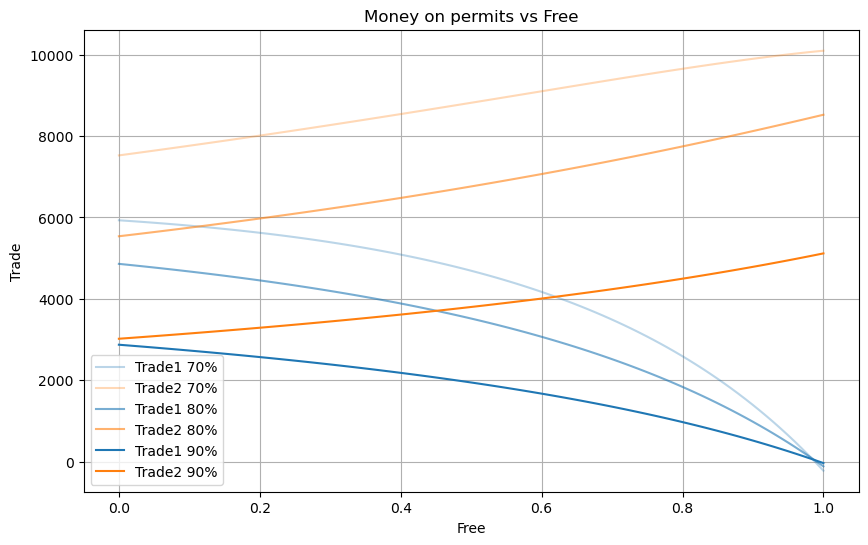

In [5]:
# Define colors and transparency levels
colors = {0.7: 'blue', 0.8: 'green', 0.9: 'red'}
alphas = {0.7: 0.3, 0.8: 0.6, 0.9: 1.0}

# Plot trades1 and trades2 with respect to frees
plt.figure(figsize=(10, 6))
for perc in [0.7, 0.8, 0.9]:
    plt.plot(frees, results[perc]['trades1'], label=f'Trade1 {perc*100:.0f}%', color='#1f77b4', alpha=alphas[perc])
    plt.plot(frees, results[perc]['trades2'], label=f'Trade2 {perc*100:.0f}%', color='#ff7f0e', alpha=alphas[perc])
plt.xlabel('Free')
plt.ylabel('Trade')
plt.title('Money on permits vs Free')
plt.legend()
plt.grid()
plt.show()


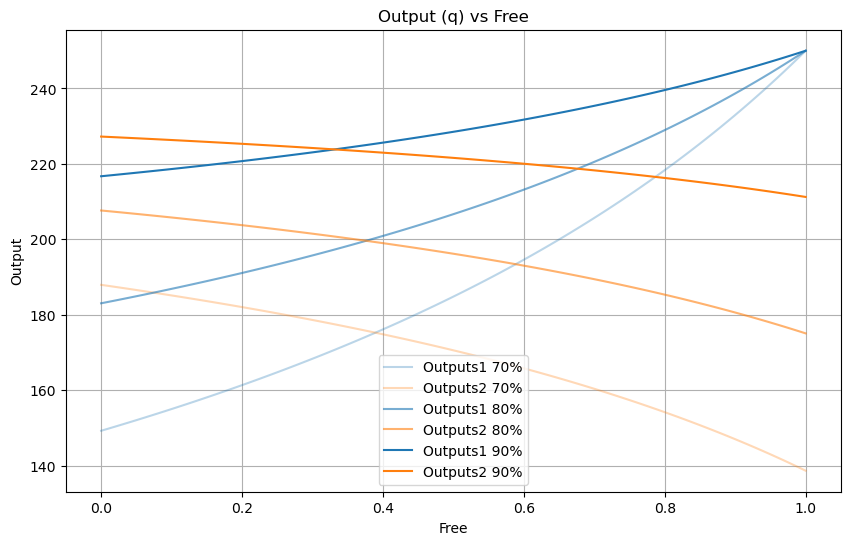

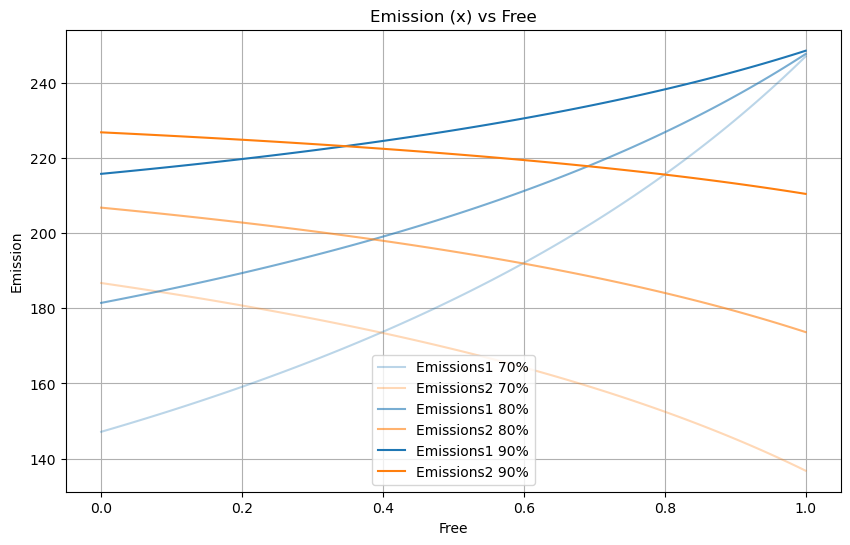

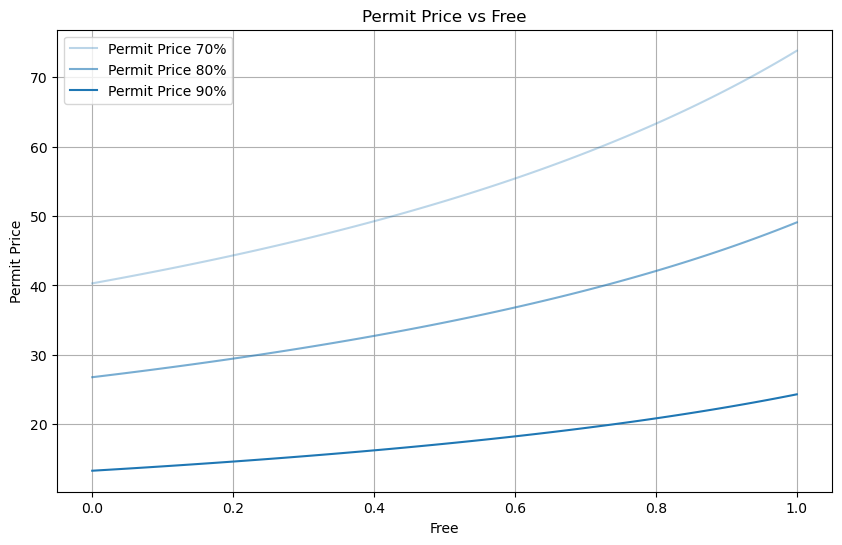

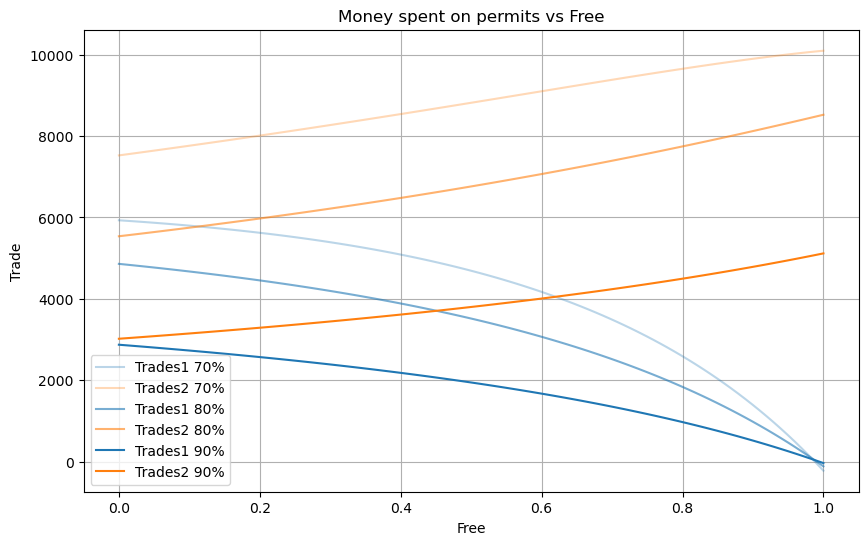

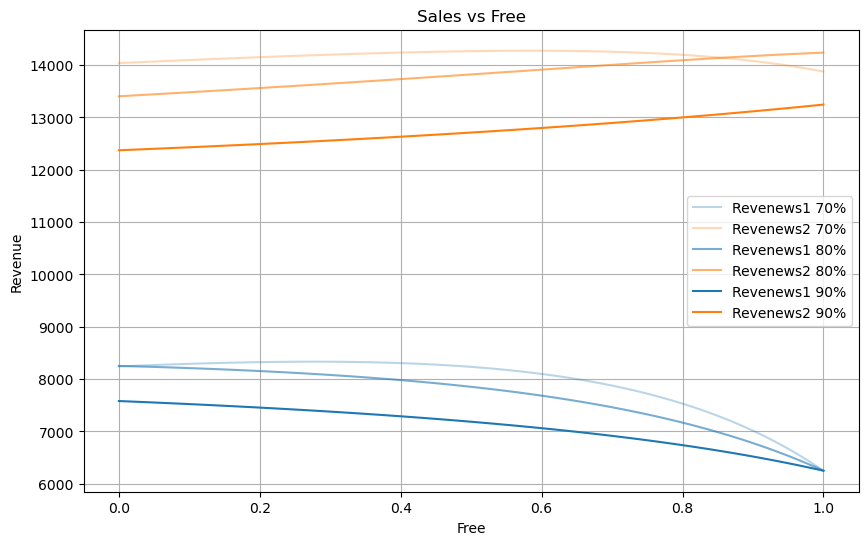

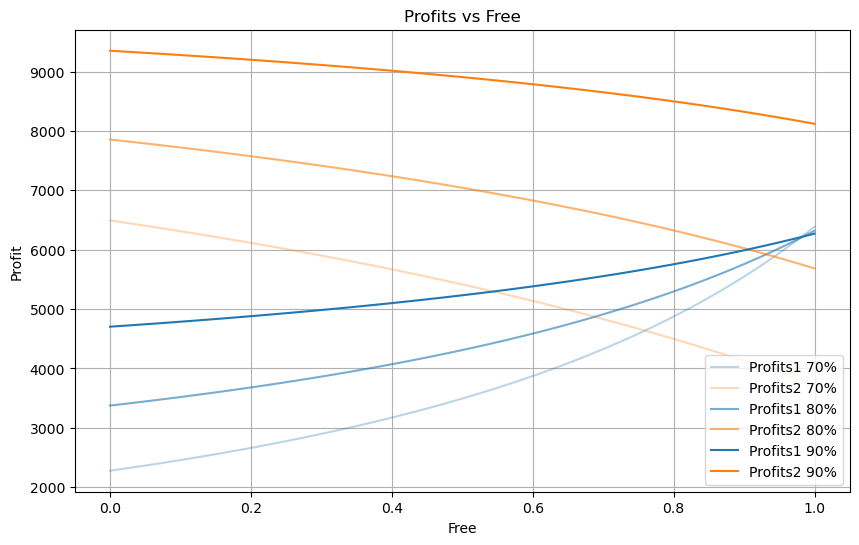

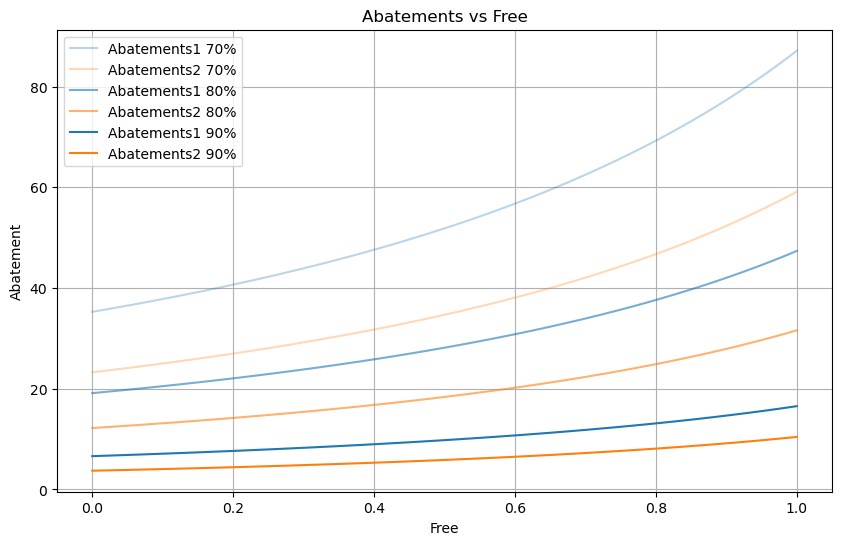

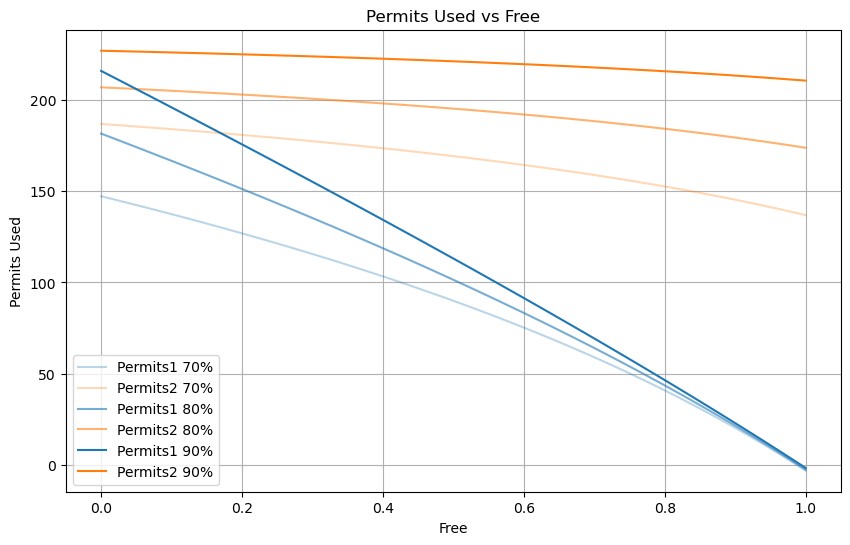

In [6]:
# Define colors and transparency levels
colors = {'trades1': '#1f77b4', 'trades2': '#ff7f0e'}
alphas = {0.7: 0.3, 0.8: 0.6, 0.9: 1.0}

# Define a function to plot the metrics
def plot_metric(metric, ylabel, title):
    plt.figure(figsize=(10, 6))
    for perc in [0.7, 0.8, 0.9]:
        plt.plot(frees, results[perc][f'{metric}1'], label=f'{metric.capitalize()}1 {perc*100:.0f}%', color=colors['trades1'], alpha=alphas[perc])
        plt.plot(frees, results[perc][f'{metric}2'], label=f'{metric.capitalize()}2 {perc*100:.0f}%', color=colors['trades2'], alpha=alphas[perc])
    plt.xlabel('Free')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

# Plot outputs
plot_metric('outputs', 'Output', 'Output (q) vs Free')

# Plot emissions
plot_metric('emissions', 'Emission', 'Emission (x) vs Free')

# Plot permit prices
plt.figure(figsize=(10, 6))
for perc in [0.7, 0.8, 0.9]:
    plt.plot(frees, results[perc]['permit_price'], label=f'Permit Price {perc*100:.0f}%', color=colors['trades1'], alpha=alphas[perc])
plt.xlabel('Free')
plt.ylabel('Permit Price')
plt.title('Permit Price vs Free')
plt.legend()
plt.grid()
plt.show()

# Plot trades
plot_metric('trades', 'Trade', 'Money spent on permits vs Free')

# Plot revenues
plot_metric('revenews', 'Revenue', 'Sales vs Free')



# Plot profits
plot_metric('profits', 'Profit', 'Profits vs Free')

# Plot abatements
plot_metric('abatements', 'Abatement', 'Abatements vs Free')

# Plot permits used
plot_metric('permits', 'Permits Used', 'Permits Used vs Free')

